## Prédiction de la prime d'assurance

Ce projet s'inscrit dans le cadre des challenges proposés par le crédit agricole via le site https://challengedata.ens.fr/  

Le but de ce challenge est de prédire la prime (charge) pure incendie d'un contrat d'assurance en utilisant deux modèles : 
- Modèle qui prédit la fréquence d'incident
- Modèle qui prédit le coût moyen  

La variable cible (charge) est obtenue en multipliant la fréquence, le coût moyen et le nombre d'année de d'assurance de l'assuré


#### **Les données**

**Les variables cibles** : Frequence , coût moyen et charge    
**Des données geographiques** : département, données météorologiques...    
**Des données spécifiques au contrat** parmi :     
- l'activité de l'assuré        
- des  indicateurs de souscription des garanties  
nombre de bâtiments, de salariés, et de sinistres déclarés lors de la souscription     
- Données de surface : surfaces des bâtiments (élevage, exploitation, etc.),anonymisées en surface1, surface2, etc...
- Données de capitaux : capitaux assurés pour différentes options (vol, serres, etc.), anonymisés en capital1, capital2, etc.
- Données liées à la prévention : présence d’équipements (extincteurs, structure en bois, etc.)

Pour un total de 374 colonnes

In [3]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

### **Exploration des données** 

In [ ]:
# données pour entrainenement et validation
train = pd.read_csv("train_input_Z61KlZo.csv")


In [42]:
train.head()

,ID,ACTIVIT2,VOCATION,TYPERS,ANCIENNETE,ADOSS,CARACT1,CARACT2,CARACT3,INDEM1,...,NBJRR100_MMAX_A,NBJRR100_MSOM_A,RR_VOR_MM_A,RR_VOR_MMAX_A,RRAB_VOR_MM_A,RRAB_VOR_MMAX_A,ANNEE_ASSURANCE,ESPINSEE,AN_EXERC,ZONE
0,1,ACT1,VOC6,1,0,N,N,NaN,NaN,N,...,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,ANNEE5,3
1,2,ACT1,VOC6,1,0,N,N,NaN,NaN,N,...,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,ANNEE5,3
2,3,ACT1,VOC6,1,2,N,R,NaN,NaN,N,...,NaN,NaN,NaN,NaN,NaN,NaN,0.402740,NaN,ANNEE5,3
3,4,ACT1,VOC6,2,0,N,N,NaN,NaN,N,...,NaN,NaN,NaN,NaN,NaN,NaN,0.246575,NaN,ANNEE5,3
4,5,ACT1,VOC6,2,1,N,N,NaN,NaN,N,...,01. <= 0,01. <= 0,03. <= 102,03. <= 232,04. >= 25,02. <= 57,0.838356,NaN,ANNEE5,3


In [5]:
# cibles freq, charge(CM) et Charge et nombre d'années d'assurance
train_output = pd.read_csv("train_output_DzPxaPY.csv")
train_output.head()

,ID,FREQ,CM,ANNEE_ASSURANCE,CHARGE
0,1,0.0,0.0,1.000000,0.0
1,2,0.0,0.0,1.000000,0.0
2,3,0.0,0.0,0.402740,0.0
3,4,0.0,0.0,0.246575,0.0
4,5,0.0,0.0,0.838356,0.0


In [ ]:
# check les duplicata
print(train.duplicated().sum())
print(train_output.duplicated().sum())

0
0
0


In [ ]:
print(train.shape)
print(train_output.shape)

(383610, 374)
(95852, 374)
(383610, 5)


In [4]:
# resume de colonnes de train
colonne = []
type = []
nb_na = []
prc_na = []
n_mod = []
ex_var = []

for col in train.columns :
    type.append(train[col].dtype)
    nb_na.append(train[col].isna().sum())
    prc_na.append(train[col].isna().sum()/len(train))
    n_mod.append( train[col].nunique())
    ex_var.append(train[col].unique()[0:3])

dico = {"col" : train.columns.tolist(),
            "type" : type,
            "NA" : nb_na,
            "%NA" : prc_na,
            "n_modalités" :n_mod,
            "exemple de var" : ex_var
    }

resume_train = pd.DataFrame(dico)

In [ ]:
resume_train
# beaucoup de variables avec plus de 50% de NA

,col,type,NA,%NA,n_modalités,exemple de var
0,ID,int64,0,0.000000,383610,"[1, 2, 3]"
1,ACTIVIT2,object,0,0.000000,9,"[ACT1, ACT2, ACT5]"
2,VOCATION,object,0,0.000000,8,"[VOC6, VOC7, VOC1]"
3,TYPERS,int64,0,0.000000,2,"[1, 2]"
4,ANCIENNETE,int64,0,0.000000,12,"[0, 2, 1]"
...,...,...,...,...,...,...
369,RRAB_VOR_MMAX_A,object,217712,0.567535,4,"[nan, 02. <= 57, 01. <= 41]"
370,ANNEE_ASSURANCE,float64,0,0.000000,1113,"[1.0, 0.402739726, 0.2465753425]"
371,ESPINSEE,object,151542,0.395042,4,"[nan, ESP3, ESP4]"
372,AN_EXERC,object,0,0.000000,9,"[ANNEE5, ANNEE4, ANNEE3]"


In [13]:
### regrouper les variables par couleurs du doc infos pour analyses

In [60]:
train.head()

,ACTIVIT2,VOCATION,TYPERS,ANCIENNETE,ADOSS,CARACT1,CARACT2,CARACT3,INDEM1,DUREE_REQANEUF,...,NBJRR100_MMAX_A,NBJRR100_MSOM_A,RR_VOR_MM_A,RR_VOR_MMAX_A,RRAB_VOR_MM_A,RRAB_VOR_MMAX_A,ANNEE_ASSURANCE,ESPINSEE,AN_EXERC,ZONE
0,ACT1,VOC6,1,0,N,N,NaN,NaN,N,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,ANNEE5,3
1,ACT1,VOC6,1,0,N,N,NaN,NaN,N,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,ANNEE5,3
2,ACT1,VOC6,1,2,N,R,NaN,NaN,N,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.402740,NaN,ANNEE5,3
3,ACT1,VOC6,2,0,N,N,NaN,NaN,N,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.246575,NaN,ANNEE5,3
4,ACT1,VOC6,2,1,N,N,NaN,NaN,N,NaN,...,01. <= 0,01. <= 0,03. <= 102,03. <= 232,04. >= 25,02. <= 57,0.838356,NaN,ANNEE5,3


Pour faciliter l'analyse des données, création de subset des colonnes

In [ ]:
rose = train.iloc[:,1:18] # activités
derog = train.iloc[:,18:34] # derog tarif
taill_ca = train.iloc[:,34:39] # taille risk, chiffres d'affiaire
capital = train.iloc[:,39:82] # capitaux
surface = train.iloc[:,82:103] # surface bat
nbBat_tailleRsk = train.iloc[:,103:118]
gris = train.iloc[:,118:141]  # inc de risk, equipement, sinitralité
dst = train.iloc[:,141:184]  # dst à point d'interet
prop = train.iloc[:,184:199]  # proportion des points d'interet
orange_pale = train.iloc[:,199:227] # ménages, logement, nb indiv
orange_orange = train.iloc[:,227:240] # alt, hauteur bat,pompiers
Temps = train.iloc[:,240:309]  # temperature
vent = train.iloc[:,309:348] 
pluie = train.iloc[:,348:370]
rest = train.iloc[:,370:]
rose = pd.concat([rose,rest],axis=1)


In [18]:
# pip install ydata-profiling[notebook]

#### EDA avec ydata_profiling

In [6]:
from ydata_profiling import ProfileReport

In [ ]:
profile_rose = ProfileReport(rose.join(train_output.drop(["ANNEE_ASSURANCE"],axis=1)), title="EDA rose")

In [ ]:
profile_rose

In [ ]:
profile_derog = ProfileReport(derog.join(train_output.drop(["ANNEE_ASSURANCE"],axis=1)), title="EDA derog")
profile_derog

In [ ]:
pd.crosstab(train_output.FREQ,derog.DEROG16)

DEROG16,OP,RE,SA,SB,SC,SP
FREQ,,,,,,
0.000000,698,869,1668,3,4,1
1.000000,1,0,6,0,0,0
1.119632,0,0,1,0,0,0
1.317690,0,0,1,0,0,0


In [120]:
derog[derog.DEROG13.isna()].DEROG1.value_counts()

DEROG1
N    382236
O        81
Name: count, dtype: int64

In [40]:
derog.DEROG1.value_counts(normalize=True)

DEROG1
N    0.999789
O    0.000211
Name: proportion, dtype: float64

In [ ]:
profil_surface_Bat = ProfileReport(surface.join(nbBat_tailleRsk), title="EDA surface")
profil_surface_Bat

In [ ]:
train[["NBSINCONJ","NBSINSTRT"]].join(train_output).corr()


,NBSINCONJ,NBSINSTRT,FREQ,CM,ANNEE_ASSURANCE,CHARGE
NBSINCONJ,1.000000,0.691775,0.011549,0.008542,-0.057169,0.008675
NBSINSTRT,0.691775,1.000000,0.016357,0.012377,-0.068506,0.012574
FREQ,0.011549,0.016357,1.000000,0.139367,-0.007190,0.141063
CM,0.008542,0.012377,0.139367,1.000000,0.003084,0.995048
ANNEE_ASSURANCE,-0.057169,-0.068506,-0.007190,0.003084,1.000000,0.003408
CHARGE,0.008675,0.012574,0.141063,0.995048,0.003408,1.000000


In [ ]:
## somme des variables CA,Kapital, Surface,nb bat

In [ ]:
# nombre total de batiment
sum_bat = nbBat_tailleRsk.iloc[:,0:13].sum(axis = 1)

In [37]:
surface.SURFACE4.value_counts()

SURFACE4
500      97717
0        75374
1000     59031
1500     37803
2000     26769
2500     20042
3000     15121
3500     11707
4000      9185
7000+     8227
4500      6695
5000      5327
5500      4215
6000      2987
6500      2501
7000       909
Name: count, dtype: int64

In [45]:
surface["SURFACE4"] = surface.SURFACE4.replace({"7000+" : "8000"})
surface["SURFACE4"] = surface["SURFACE4"].astype("int")
surface["SURFACE6"] = surface.SURFACE6.replace({"7000+" : "8000"})
surface["SURFACE6"] = surface["SURFACE6"].astype("int")

In [ ]:
# somme des capitaux
sum_capital = capital.select_dtypes("number").sum(axis = 1)


In [ ]:
# somme du chiffre d'affaire
sum_CA = taill_ca.iloc[:,2:].sum(axis=1)

In [14]:
taill_ca.head()

,TAILLE1,TAILLE2,CA1,CA2,CA3
0,05 - [1M - 1.5M],05 - [750k- 1M],0,0,0
1,02 - [250k-500k],03 - [250k-500k],0,0,0
2,01 - [0 -250k],02 - [100k-250k],30000,0,0
3,01 - [0 -250k],02 - [100k-250k],0,0,0
4,01 - [0 -250k],02 - [100k-250k],0,0,0


<Axes: xlabel='CM', ylabel='TAILLE1'>

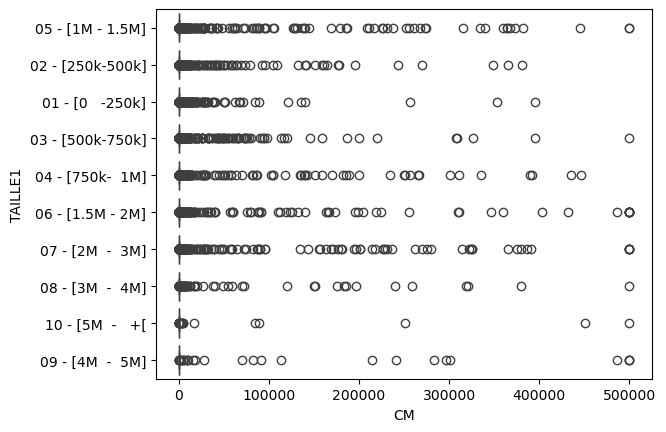

In [ ]:
sns.boxplot(x="CM",y="TAILLE1", data = train.join(train_output.drop(["ID","ANNEE_ASSURANCE"],axis = 1))[train_output["CM"]>=0],orient='h')
plt.title("Charge en fonction de la taille de risque 1");

<Axes: xlabel='CM', ylabel='TAILLE1'>

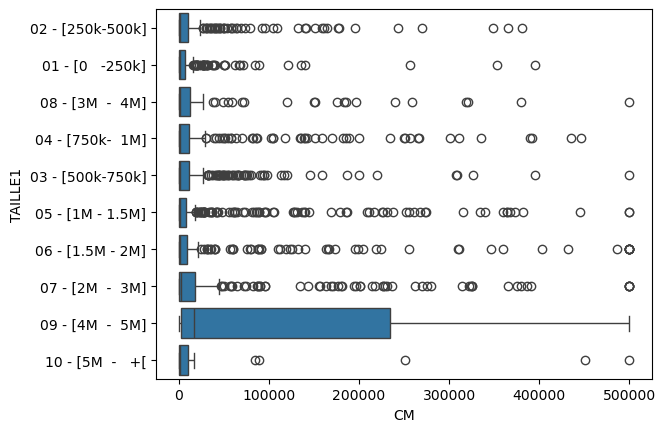

In [ ]:
# CM en focntion de la taille du risk 1 et CM > 0 
sns.boxplot(x="CM",y="TAILLE1", data = train.join(train_output.drop(["ID","ANNEE_ASSURANCE"],axis = 1))[train_output["CM"]>0],orient='h')
plt.title("Charge en fonction de la taille de risque quand charge > 0");

<Axes: xlabel='FREQ', ylabel='TAILLE1'>

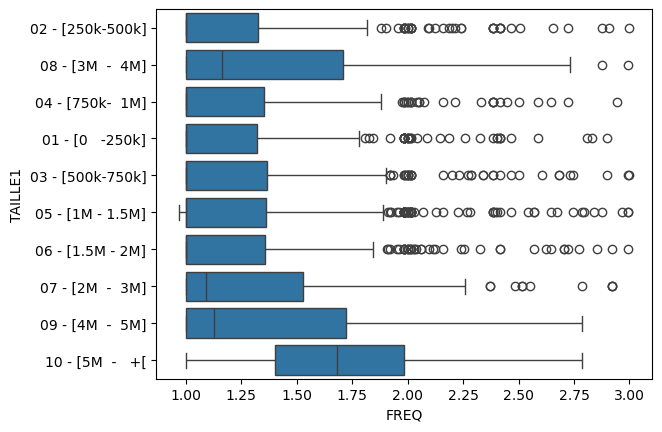

In [ ]:
# FREQ en focntion de la taille du risk 1 et freq compris entre 0 et 3

sns.boxplot(x="FREQ",y="TAILLE1"
            , data = train.join(train_output.drop(["ID","ANNEE_ASSURANCE"],axis = 1))[(train_output["FREQ"]>0) &(train_output["FREQ"]<=3) ]
            ,orient='h')

plt.title("Frequence en fonction de la taille de risque 1 quand quand la 0 < fréquence < 3")

In [101]:
train.TAILLE1.value_counts(normalize=False,dropna=False)

TAILLE1
01 - [0   -250k]    126652
02 - [250k-500k]     79214
03 - [500k-750k]     50552
05 - [1M - 1.5M]     42991
04 - [750k-  1M]     34424
06 - [1.5M - 2M]     23073
07 - [2M  -  3M]     18786
08 - [3M  -  4M]      5113
09 - [4M  -  5M]      1777
10 - [5M  -   +[      1028
Name: count, dtype: int64

<Axes: xlabel='FREQ', ylabel='TAILLE2'>

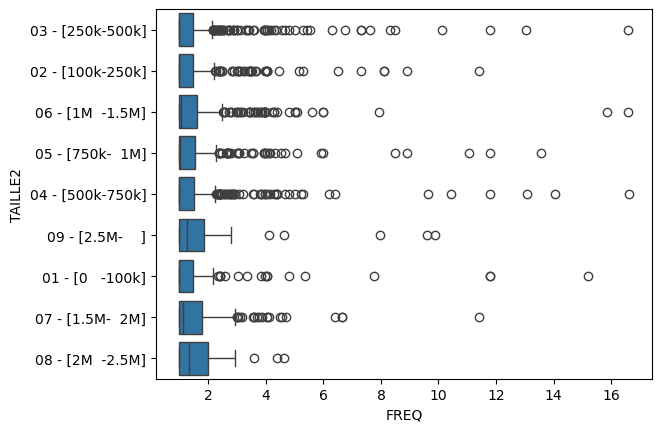

In [ ]:
# FREQ en focntion de la taille du risk 2 et freq < 3 et >0
sns.boxplot(x="FREQ",y="TAILLE2"
            , data = train.join(train_output.drop(["ID","ANNEE_ASSURANCE"],axis = 1))[(train_output["FREQ"]>0) &(train_output["FREQ"]<=20) ]
            ,orient='h')
plt.title("Frequence en fonction de la taille de risque 1 quand quand la 0 < fréquence < 20");


## Nettoyage des cibles

In [10]:
train_output.describe()
# valeur négative dans CM
# grande range de valeur pour Frq et CM

,ID,FREQ,CM,ANNEE_ASSURANCE,CHARGE
count,383610.000000,383610.000000,383610.000000,383610.000000,383610.000000
mean,191805.500000,0.012452,182.521632,0.701557,186.087058
std,110738.812719,0.357127,6699.967429,0.352375,6800.490328
min,1.000000,0.000000,-5751.000000,0.002732,-5751.000000
25%,95903.250000,0.000000,0.000000,0.389041,0.000000
50%,191805.500000,0.000000,0.000000,0.882192,0.000000
75%,287707.750000,0.000000,0.000000,1.000000,0.000000
max,383610.000000,182.499998,500000.000000,2.000000,552000.000000


In [11]:
train_output = abs(train_output)
train_output.describe()

,ID,FREQ,CM,ANNEE_ASSURANCE,CHARGE
count,383610.000000,383610.000000,383610.000000,383610.000000,383610.000000
mean,191805.500000,0.012452,182.593925,0.701557,186.159351
std,110738.812719,0.357127,6699.965459,0.352375,6800.488350
min,1.000000,0.000000,0.000000,0.002732,0.000000
25%,95903.250000,0.000000,0.000000,0.389041,0.000000
50%,191805.500000,0.000000,0.000000,0.882192,0.000000
75%,287707.750000,0.000000,0.000000,1.000000,0.000000
max,383610.000000,182.499998,500000.000000,2.000000,552000.000000


In [39]:
# vérifie que si FREQ = 0 alors CM = 0
train_output[(train_output["CM"]>0)&(train_output["FREQ"]==0)]


,ID,FREQ,CM,ANNEE_ASSURANCE,CHARGE


In [40]:
# fréquence d'incident positif mais CM nul
train_output[(train_output["CM"]==0)&(train_output["FREQ"]>0)]
# considérer que c'est une erreur dans les données ou pas ?

,ID,FREQ,CM,ANNEE_ASSURANCE,CHARGE
665,666,1.000000,0.0,1.000000,0.0
1150,1151,1.092814,0.0,0.915068,0.0
1317,1318,1.000000,0.0,1.000000,0.0
1525,1526,1.834171,0.0,0.545205,0.0
1744,1745,1.000000,0.0,1.000000,0.0
...,...,...,...,...,...
372374,372375,1.000000,0.0,1.000000,0.0
374185,374186,1.000000,0.0,1.000000,0.0
378044,378045,1.048851,0.0,0.953425,0.0
378206,378207,1.000000,0.0,1.000000,0.0


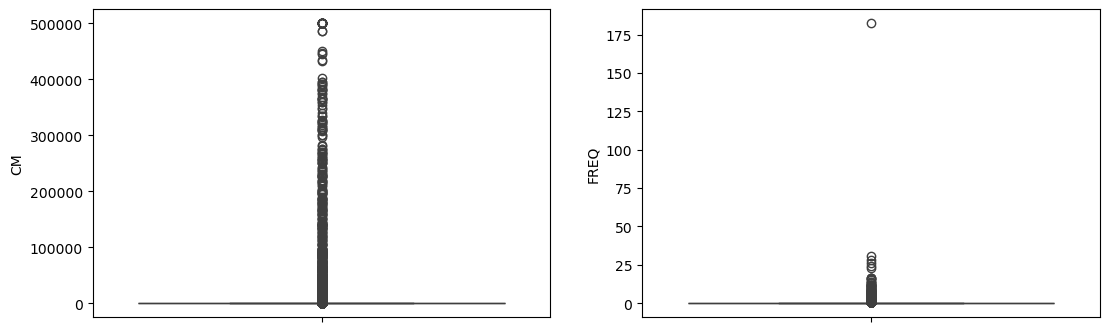

In [19]:
plt.figure(figsize=(13,4))

plt.subplot(121)
sns.boxplot(train_output["CM"])

plt.subplot(122)
sns.boxplot(train_output["FREQ"])

plt.show()

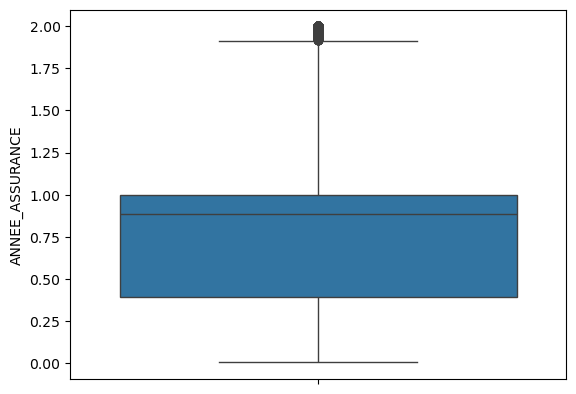

In [55]:
sns.boxplot(train_output["ANNEE_ASSURANCE"]);


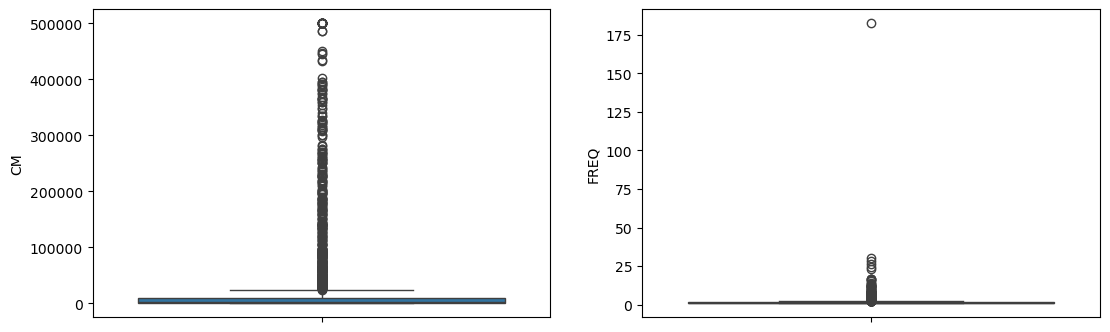

In [21]:
plt.figure(figsize=(13,4))

plt.subplot(121)
sns.boxplot(train_output["CM"][train_output["CM"]>0])

plt.subplot(122)
sns.boxplot(train_output["FREQ"][train_output["FREQ"]>0])

plt.show()

<span style="font-size:15px">

Les variables sont extrêmement dispersées

</span>

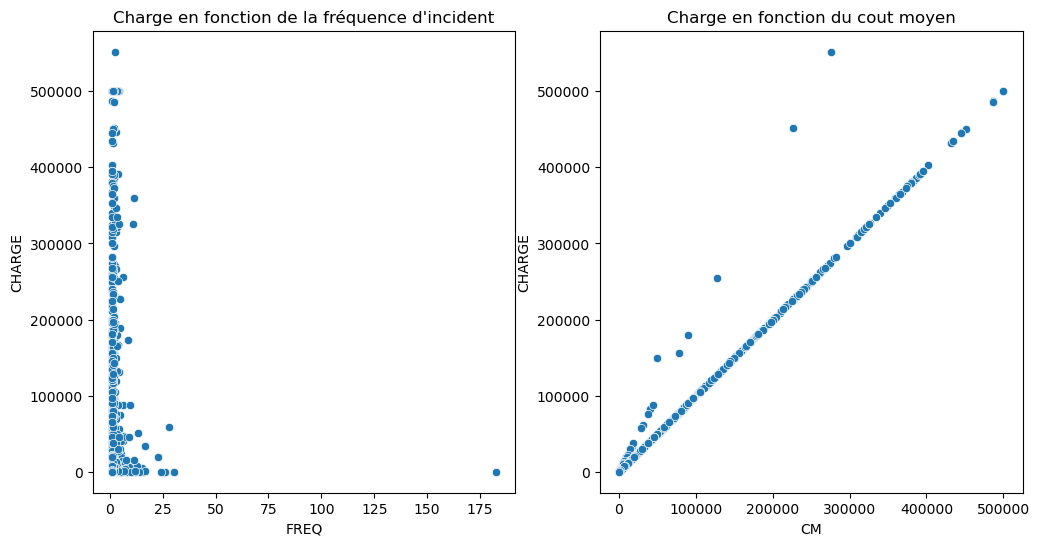

In [29]:
plt.figure(figsize=(12,6))

plt.subplot(121)
sns.scatterplot(x= "FREQ",y="CHARGE", data = train_output[train_output["FREQ"]>0] )
plt.title("Charge en fonction de la fréquence d'incident")

plt.subplot(122)
sns.scatterplot(x= "CM",y="CHARGE", data = train_output[train_output["FREQ"]>0] )
plt.title("Charge en fonction du cout moyen");

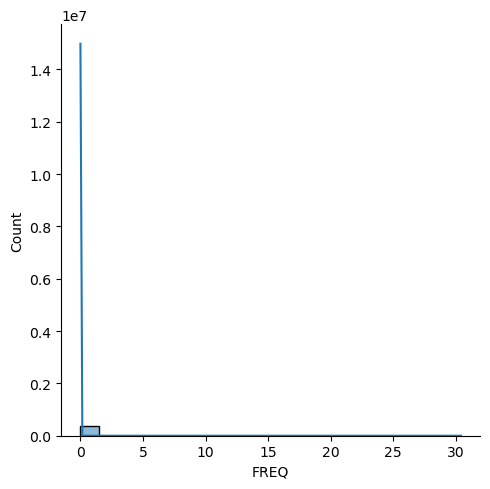

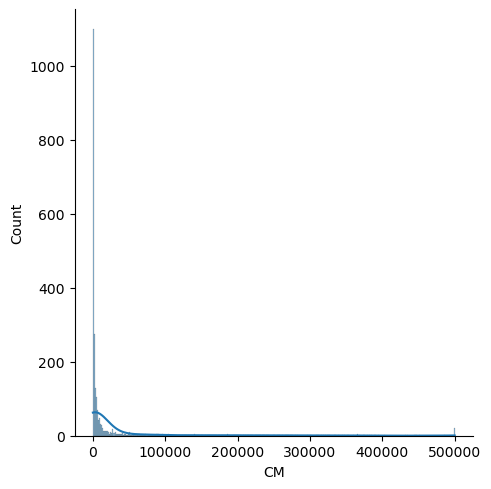

In [35]:
sns.displot(train_output["FREQ"][train_output["FREQ"]<50],kde=True)

sns.displot(train_output["CM"][train_output["CM"]>0],kde=True);

In [ ]:
# transformation box-cox sur CM et FREQ pour obtenir des distributions plus ou moins normales
from scipy.stats import boxcox
from scipy.special import inv_boxcox

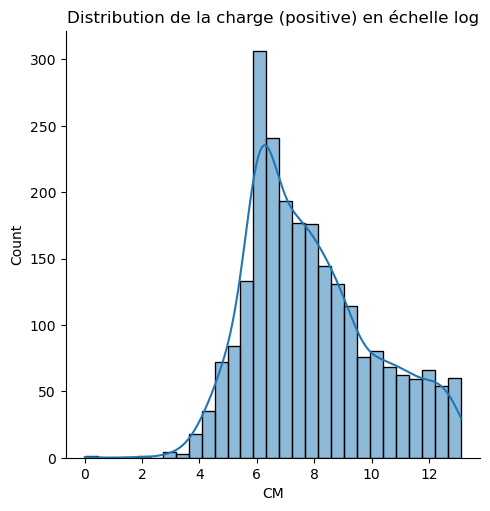

In [47]:
# log de CM exclu 0
sns.displot(np.log(train_output["CM"][train_output["CM"]>0]),kde=True)
plt.title("Distribution de la charge (positive) en échelle log");

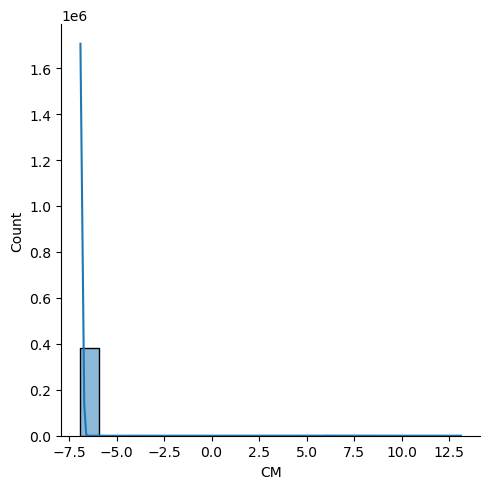

In [45]:
# log de CM ajout decémil pour évite 0
sns.displot(np.log(train_output["CM"]+0.001),kde=True);

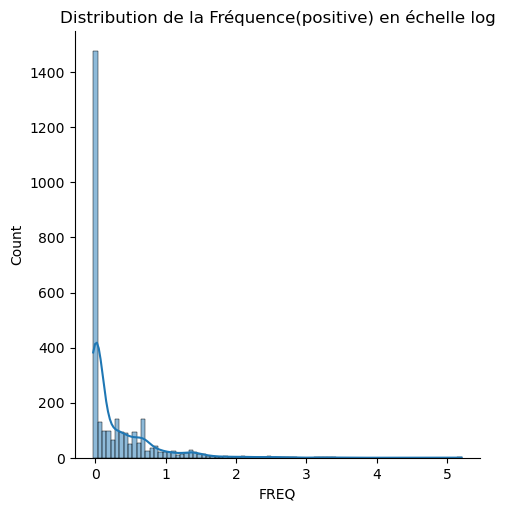

In [49]:
# log de FREQ exclu 0
sns.displot(np.log(train_output["FREQ"][train_output["FREQ"]>0]),kde=True)
plt.title("Distribution de la Fréquence(positive) en échelle log");

#### **gestion des outliers**

In [58]:
from scipy.stats import median_abs_deviation,iqr

Explore les outliers supérieur avec méthode IQR et MAD

In [68]:
# FREQ = nb_sinitre / ANNE ASSURANCE
# Quand l'annee d'assurance est inf à 1 ==> tres grande valeur même si un seul sinistre
# on calcule de nombre de sinistre
train_output["NbSinistre"] = train_output["ANNEE_ASSURANCE"]*train_output["FREQ"]
train_output.describe()

,ID,FREQ,CM,ANNEE_ASSURANCE,CHARGE,NbSinistre
count,383610.000000,383610.000000,383610.000000,383610.000000,383610.000000,383610.000000
mean,191805.500000,0.012452,182.593925,0.701557,186.159351,0.007831
std,110738.812719,0.357127,6699.965459,0.352375,6800.488350,0.091654
min,1.000000,0.000000,0.000000,0.002732,0.000000,0.000000
25%,95903.250000,0.000000,0.000000,0.389041,0.000000,0.000000
50%,191805.500000,0.000000,0.000000,0.882192,0.000000,0.000000
75%,287707.750000,0.000000,0.000000,1.000000,0.000000,0.000000
max,383610.000000,182.499998,500000.000000,2.000000,552000.000000,5.000000


In [69]:
train_output[(train_output["ANNEE_ASSURANCE"]<0.08356164384999998) &(train_output["FREQ"]>0)]

,ID,FREQ,CM,ANNEE_ASSURANCE,CHARGE,NbSinistre
4508,4509,13.035714,670.00,0.076712,670.00,1.0
18611,18612,16.590909,890.00,0.060274,890.00,1.0
25331,25332,26.071429,48.00,0.038356,48.00,1.0
33093,33094,15.869565,120.00,0.063014,120.00,1.0
36402,36403,15.208333,5520.00,0.065753,5520.00,1.0
76191,76192,16.590909,1110.00,0.060274,1110.00,1.0
77050,77051,22.812500,18920.57,0.043836,18920.57,1.0
80589,80590,30.416667,0.00,0.032877,0.00,1.0
103864,103865,28.153846,59033.90,0.035519,59033.90,1.0
116544,116545,13.071429,7866.58,0.076503,7866.58,1.0


In [70]:
train_output[train_output.FREQ >2]
# FREQ = nb_sinitre / ANNE ASSURANCE
# Quand l'annee d'assurance est inf à 1 ==> tres grande valeur même si un seul sinistre

,ID,FREQ,CM,ANNEE_ASSURANCE,CHARGE,NbSinistre
424,425,3.258929,22470.51,0.306849,22470.51,1.0
1161,1162,2.239264,35822.81,0.446575,35822.81,1.0
1624,1625,3.364055,3540.99,0.594521,7081.98,2.0
1832,1833,9.605263,1378.33,0.104110,1378.33,1.0
2164,2165,2.588652,670.00,0.386301,670.00,1.0
...,...,...,...,...,...,...
373915,373916,2.851563,13155.89,0.350685,13155.89,1.0
374838,374839,3.119658,5441.00,0.320548,5441.00,1.0
375716,375717,4.147727,30359.00,0.241096,30359.00,1.0
378985,378986,3.967391,1600.00,0.252055,1600.00,1.0


In [78]:
# check si lignes où la charge ne correspond pas à CM*Freq*Annee_Assurance
train_output[train_output["CHARGE"] != (train_output["CM"]*train_output["FREQ"]*train_output["ANNEE_ASSURANCE"]).round(2)]


,ID,FREQ,CM,ANNEE_ASSURANCE,CHARGE,NbSinistre


In [80]:
# comme il a y beaucoup 0 les stats de CM et FREQ sont de 0. Donc pour calculer les outlier on exclu les 0

for col in train_output[["CM","FREQ"]] :
    print(col)
    print(col,"outlier sup MAD (sans 0)", np.median(train_output[col][train_output[col]>0]) + 3.5*median_abs_deviation(train_output[col][train_output[col]>0]))
    print(col,"outlier sup IQR (sans 0)", np.quantile(train_output[col][train_output[col]>0],0.75) + 1.5*iqr(train_output[col][train_output[col]>0]))
    print(col,"outlier sup std (sans 0)", np.mean(train_output[col][train_output[col] >0]) + 2* np.std(train_output[col][train_output[col] >0]))
    print(col,"outlier sup std (avec 0)", np.mean(train_output[col]) + 2* np.std(train_output[col]),"\n")

CM
CM outlier sup MAD (sans 0) 7146.324999999999
CM outlier sup IQR (sans 0) 24244.63875
CM outlier sup std (sans 0) 190027.83630142178
CM outlier sup std (avec 0) 13582.507377979686 

FREQ
FREQ outlier sup MAD (sans 0) 1.0061813186193362
FREQ outlier sup IQR (sans 0) 2.382978723635582
FREQ outlier sup std (sans 0) 9.187660016656364
FREQ outlier sup std (avec 0) 0.7267045012098446 



In [82]:
# outlier sup des cibles pour differentes méthodes

for col in train_output[["CM","FREQ"]] :
    print(col)
    print(col,"outlier sup MAD 3.5 ", np.median(train_output[col][train_output[col]>0]) + 3.5*median_abs_deviation(train_output[col][train_output[col]>0]))
    print(col,"outlier sup MAD 3 ", np.median(train_output[col][train_output[col]>0]) + 3*median_abs_deviation(train_output[col][train_output[col]>0]))
    print(col,"outlier sup MAD 3.29 ", np.median(train_output[col][train_output[col]>0]) + 3.29*median_abs_deviation(train_output[col][train_output[col]>0]))
    
    print(col,"outlier sup IQR 1.5 ", np.quantile(train_output[col][train_output[col]>0],0.75) + 1.5*iqr(train_output[col][train_output[col]>0]))
    print(col,"outlier sup IQR 3 ", np.quantile(train_output[col][train_output[col]>0],0.75) + 3*iqr(train_output[col][train_output[col]>0]))

    print(col,"outlier sup std 2 ", np.mean(train_output[col][train_output[col] >0]) + 2* np.std(train_output[col][train_output[col] >0]))
    print(col,"outlier sup std 2.5 ", np.mean(train_output[col][train_output[col] >0]) + 2.5* np.std(train_output[col][train_output[col] >0]))
    print(col,"outlier sup std 3 ", np.mean(train_output[col][train_output[col] >0]) + 3* np.std(train_output[col][train_output[col] >0]),"\n")

CM
CM outlier sup MAD 3.5  7146.324999999999
CM outlier sup MAD 3  6380.65
CM outlier sup MAD 3.29  6824.7415
CM outlier sup IQR 1.5  24244.63875
CM outlier sup IQR 3  38500.4925
CM outlier sup std 2  190027.83630142178
CM outlier sup std 2.5  230108.49601934155
CM outlier sup std 3  270189.1557372613 

FREQ
FREQ outlier sup MAD 3.5  1.0061813186193362
FREQ outlier sup MAD 3  1.00549450543941
FREQ outlier sup MAD 3.29  1.0058928570837673
FREQ outlier sup IQR 1.5  2.382978723635582
FREQ outlier sup IQR 3  3.2127659578169316
FREQ outlier sup std 2  9.187660016656364
FREQ outlier sup std 2.5  11.071941792617517
FREQ outlier sup std 3  12.956223568578668 



In [ ]:
### virer les outliers de FREQ et CM
# CM 24244.63875


#  outlier std : 9.18
freq_out_std = np.mean(train_output["FREQ"][train_output["FREQ"] >0]) + 2* np.std(train_output["FREQ"][train_output["FREQ"] >0]) #  9.18
# outlier IQR 1.5  : 2.38
freq_out_iqr = np.quantile(train_output["FREQ"][train_output["FREQ"]>0],0.75) + 1.5*iqr(train_output["FREQ"][train_output["FREQ"]>0]) 

# outlier iqr 1.5 : 24244
cm_out_iqr = np.quantile(train_output["CM"][train_output["CM"]>0],0.75) + 1.5*iqr(train_output["CM"][train_output["CM"]>0]) # 24244.63875
# outlier std 2 : 190027
cm_out_std = np.mean(train_output["CM"][train_output["CM"] >0]) + 2* np.std(train_output["CM"][train_output["CM"] >0]) # 190027.83630142178

In [84]:
# si valeur inf à limite on met NA
CM_IQR = [cm if cm <= cm_out_iqr else np.nan for cm in train_output["CM"]]
CM_STD = [cm if cm <= cm_out_std else np.nan for cm in train_output["CM"]]

FREQ_STD = [frq if frq <= freq_out_std else np.nan for frq in train_output["FREQ"]]
FREQ_IQR = [frq if frq <= freq_out_iqr else np.nan for frq in train_output["FREQ"]]


In [85]:
train_output["CM_IQR"] = CM_IQR
train_output["CM_STD"] = CM_STD

train_output["FREQ_STD"] = FREQ_STD
train_output["FREQ_IQR"] = FREQ_IQR

train_output.describe()

,ID,FREQ,CM,ANNEE_ASSURANCE,CHARGE,NbSinistre,CM_IQR,CM_STD,FREQ_STD,FREQ_IQR
0,1,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.0,0.0,0.402740,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.0,0.0,0.246575,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.0,0.0,0.838356,0.0,0.0,0.0,0.0,0.0,0.0


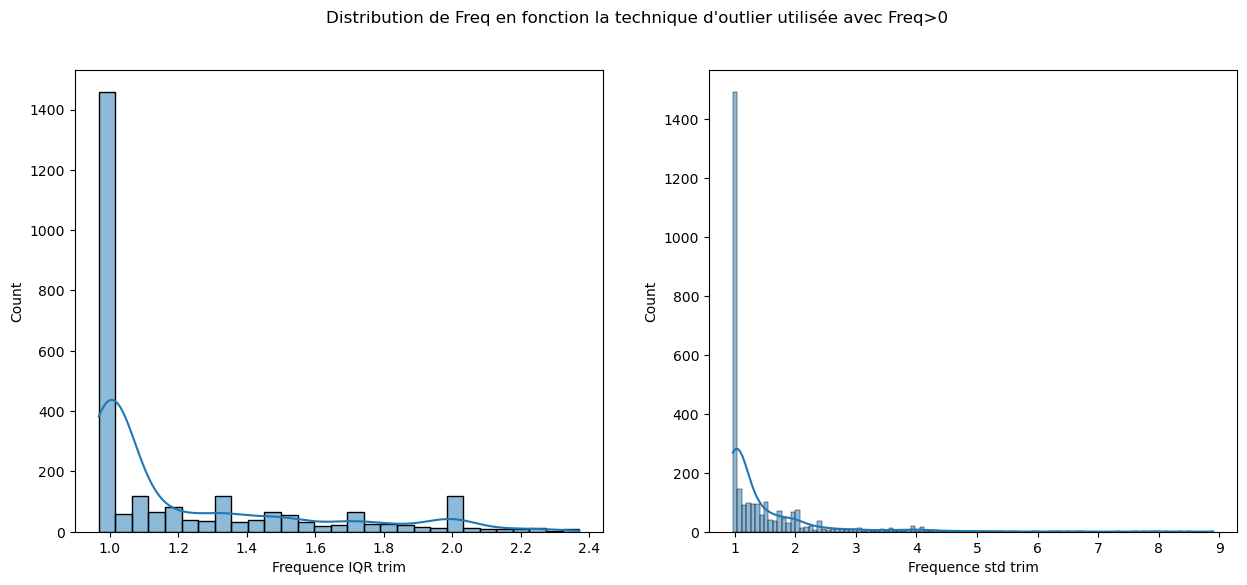

In [101]:
plt.figure(figsize=(15,6))
plt.suptitle("Distribution de Freq en fonction la technique d'outlier utilisée avec Freq>0")
plt.subplot(121)
sns.histplot((train_output["FREQ_IQR"][train_output["FREQ_IQR"]>0]),kde=True)
plt.xlabel("Frequence IQR trim")
plt.subplot(122)
sns.histplot((train_output["FREQ_STD"][train_output["FREQ_STD"]>0]),kde=True)
plt.xlabel("Frequence std trim")

plt.show()

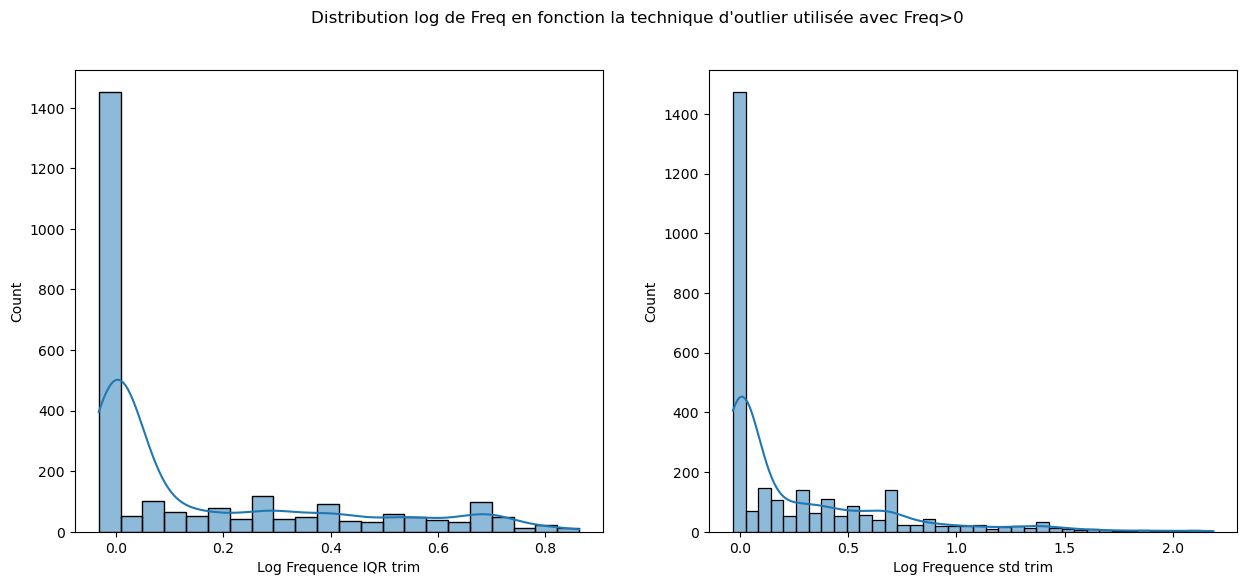

In [102]:
plt.figure(figsize=(15,6))

plt.suptitle("Distribution log de Freq en fonction la technique d'outlier utilisée avec Freq>0")
plt.subplot(121)
sns.histplot(np.log(train_output["FREQ_IQR"][train_output["FREQ_IQR"]>0]),kde=True)
plt.xlabel("Log Frequence IQR trim")

plt.subplot(122)
sns.histplot(np.log(train_output["FREQ_STD"][train_output["FREQ_STD"]>0]),kde=True)
plt.xlabel("Log Frequence std trim")

plt.show()

## Nettoyage de X

### nettoyage de rose

In [180]:
rose.head()

,ACTIVIT2,VOCATION,TYPERS,ANCIENNETE,ADOSS,CARACT1,CARACT2,CARACT3,INDEM1,DUREE_REQANEUF,...,CARACT5,TYPBAT1,INDEM2,TYPBAT2,FRCH1,FRCH2,ANNEE_ASSURANCE,ESPINSEE,AN_EXERC,ZONE
0,ACT1,VOC6,1,0,N,N,NaN,NaN,N,NaN,...,0,NaN,CLASS5,0,2,NaN,1.000000,NaN,ANNEE5,3
1,ACT1,VOC6,1,0,N,N,NaN,NaN,N,NaN,...,0,NaN,CLASS6,0,1,NaN,1.000000,NaN,ANNEE5,3
2,ACT1,VOC6,1,2,N,R,NaN,NaN,N,NaN,...,0,NaN,CLASS6,0,1,NaN,0.402740,NaN,ANNEE5,3
3,ACT1,VOC6,2,0,N,N,NaN,NaN,N,NaN,...,0,NaN,CLASS8,0,1,NaN,0.246575,NaN,ANNEE5,3
4,ACT1,VOC6,2,1,N,N,NaN,NaN,N,NaN,...,0,NaN,CLASS9,0,1,NaN,0.838356,NaN,ANNEE5,3


In [184]:
rose.columns

Index(['ACTIVIT2', 'VOCATION', 'TYPERS', 'ANCIENNETE', 'ADOSS', 'CARACT1',
       'CARACT2', 'CARACT3', 'INDEM1', 'DUREE_REQANEUF', 'CARACT4', 'CARACT5',
       'TYPBAT1', 'INDEM2', 'TYPBAT2', 'FRCH1', 'FRCH2', 'ANNEE_ASSURANCE',
       'ESPINSEE', 'AN_EXERC', 'ZONE'],
      dtype='object')

In [107]:
rose.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383610 entries, 0 to 383609
Data columns (total 21 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   ACTIVIT2         383610 non-null  object 
 1   VOCATION         383610 non-null  object 
 2   TYPERS           383610 non-null  int64  
 3   ANCIENNETE       383610 non-null  int64  
 4   ADOSS            383610 non-null  object 
 5   CARACT1          378977 non-null  object 
 6   CARACT2          15326 non-null   float64
 7   CARACT3          15326 non-null   object 
 8   INDEM1           383610 non-null  object 
 9   DUREE_REQANEUF   357037 non-null  float64
 10  CARACT4          383610 non-null  object 
 11  CARACT5          383610 non-null  int64  
 12  TYPBAT1          30274 non-null   object 
 13  INDEM2           356238 non-null  object 
 14  TYPBAT2          383610 non-null  int64  
 15  FRCH1            383610 non-null  object 
 16  FRCH2            357037 non-null  obje

In [19]:
rose.describe()

,TYPERS,ANCIENNETE,CARACT2,DUREE_REQANEUF,CARACT5,TYPBAT2,ANNEE_ASSURANCE,ZONE
count,383610.000000,383610.000000,15326.000000,357037.000000,383610.000000,383610.000000,383610.000000,383610.000000
mean,1.665368,5.175517,1.019053,2.200483,0.076515,1.061711,0.701557,49.046876
std,0.471862,3.823097,0.136714,1.300343,0.420928,0.831133,0.352375,27.919867
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.002732,1.000000
25%,1.000000,2.000000,1.000000,2.000000,0.000000,0.000000,0.389041,25.000000
50%,2.000000,5.000000,1.000000,2.000000,0.000000,1.000000,0.882192,49.000000
75%,2.000000,9.000000,1.000000,2.000000,0.000000,2.000000,1.000000,73.000000
max,2.000000,11.000000,2.000000,10.000000,20.000000,2.000000,2.000000,95.000000


In [108]:
rose.isna().sum()

ACTIVIT2                0
VOCATION                0
TYPERS                  0
ANCIENNETE              0
ADOSS                   0
CARACT1              4633
CARACT2            368284
CARACT3            368284
INDEM1                  0
DUREE_REQANEUF      26573
CARACT4                 0
CARACT5                 0
TYPBAT1            353336
INDEM2              27372
TYPBAT2                 0
FRCH1                   0
FRCH2               26573
ANNEE_ASSURANCE         0
ESPINSEE           151542
AN_EXERC                0
ZONE                    0
dtype: int64

In [109]:
# afficher les valeurs unique pour toute les colonnes
for i in rose.columns :
    print(train[i].value_counts())

# typer = obj
# caract 2 = int puis obj
# caract 5 = obj
# typebat 2 = obj
# frch1 et 2 corrigé valeur
# zone = obj

ACTIVIT2
ACT1    296563
ACT5     53709
ACT2     14359
ACT8      5650
ACT3      5335
ACT9      4459
ACT7      2201
ACT6      1007
ACT4       327
Name: count, dtype: int64
VOCATION
VOC6    244441
VOC8     67446
VOC7     38967
VOC4     15289
VOC1     14359
VOC2      1952
VOC3      1081
VOC5        75
Name: count, dtype: int64
TYPERS
2    255242
1    128368
Name: count, dtype: int64
ANCIENNETE
11    61239
0     49545
1     38549
2     35612
3     33038
4     30286
5     27594
6     25226
7     23305
8     21489
9     19923
10    17804
Name: count, dtype: int64
ADOSS
N    375557
O      8053
Name: count, dtype: int64
CARACT1
N    274335
R     93158
O     11484
Name: count, dtype: int64
CARACT2
1.0    15034
2.0      292
Name: count, dtype: int64
CARACT3
N    7433
O    6795
R    1098
Name: count, dtype: int64
INDEM1
N    365728
O     17882
Name: count, dtype: int64
DUREE_REQANEUF
2.0     331032
5.0       9100
0.0       9096
10.0      7809
Name: count, dtype: int64
CARACT4
absence de surface   

In [110]:
# change le type des colonnes
#typer = obj
# caract 2 = int puis obj
# caract 5 = obj
# typebat 2 = obj
# frch1 et 2 corrigé valeur
# zone = obj
train = train.astype({"TYPERS" : "object",
              "CARACT2" : "object",
              "CARACT5" : "object",
              "TYPBAT2" : "object",
              "ZONE" : "object"})

rose = rose.astype({"TYPERS" : "object",
              "CARACT2" : "object",
              "CARACT5" : "object",
              "TYPBAT2" : "object",
              "ZONE" : "object"})


In [111]:
rose.FRCH1.value_counts()


FRCH1
0    169031
1    102148
0     73268
1     24697
2      9894
3      2185
2      1899
3       424
i        64
Name: count, dtype: int64

In [112]:
# corrige les modalités
rose.FRCH1 = np.where(rose.FRCH1 == "i",rose.FRCH1.mode()[0],rose.FRCH1)
train.FRCH1 = np.where(train.FRCH1 == "i",train.FRCH1.mode()[0],train.FRCH1)

In [113]:
rose.FRCH1.value_counts()

FRCH1
0    169095
1    102148
0     73268
1     24697
2      9894
3      2185
2      1899
3       424
Name: count, dtype: int64

In [115]:
# rassemble les modalités
rose.FRCH1 = rose.FRCH1.astype("int").astype("object")

train.FRCH1 = train.FRCH1.astype("int").astype("object")
rose.FRCH1.value_counts()

FRCH1
0    242363
1    126845
2     11793
3      2609
Name: count, dtype: int64

In [24]:
train[rose.columns].dtypes

ACTIVIT2            object
VOCATION            object
TYPERS              object
ANCIENNETE           int64
ADOSS               object
CARACT1             object
CARACT2             object
CARACT3             object
INDEM1              object
DUREE_REQANEUF     float64
CARACT4             object
CARACT5             object
TYPBAT1             object
INDEM2              object
TYPBAT2             object
FRCH1               object
FRCH2               object
ANNEE_ASSURANCE    float64
ESPINSEE            object
AN_EXERC            object
ZONE                object
dtype: object

In [117]:
### définir fonction pour les changement à faire sur le test

def rose_clean(df) : 
    
    df.FRCH1 = np.where(df.FRCH1 == "i",df.FRCH1.mode()[0],df.FRCH1)
    df.FRCH1 = np.where(df.FRCH1 == "i",df.FRCH1.mode()[0],df.FRCH1)
    df.FRCH1 = df.FRCH1.astype("int").astype("object")

    # modif le type des variables
    df = df.astype({"TYPERS" : "object",
              "CARACT2" : "object",
              "CARACT5" : "object",
              "TYPBAT2" : "object",
              "ZONE" : "object"})
        
    return df
     

In [118]:
train = rose_clean(train)

In [119]:
rose.isna().sum()/len(rose)

ACTIVIT2           0.000000
VOCATION           0.000000
TYPERS             0.000000
ANCIENNETE         0.000000
ADOSS              0.000000
CARACT1            0.012077
CARACT2            0.960048
CARACT3            0.960048
INDEM1             0.000000
DUREE_REQANEUF     0.069271
CARACT4            0.000000
CARACT5            0.000000
TYPBAT1            0.921081
INDEM2             0.071354
TYPBAT2            0.000000
FRCH1              0.000000
FRCH2              0.069271
ANNEE_ASSURANCE    0.000000
ESPINSEE           0.395042
AN_EXERC           0.000000
ZONE               0.000000
dtype: float64

In [235]:
rose.isna().mean()[rose.isna().mean() >= 0.50].index
# colonne ou 50% ou plus de NA (assume que valeur manquante = absence de caractéristique)

Index(['CARACT2', 'CARACT3', 'TYPBAT1'], dtype='object')

### nettoyage de derog

In [ ]:
# contient colonne dérogation tarifaires

In [120]:
derog.head()

,DEROG1,DEROG2,DEROG3,DEROG4,DEROG5,DEROG6,DEROG7,DEROG8,DEROG9,DEROG10,DEROG11,DEROG12,DEROG13,DEROG14,DEROG15,DEROG16
0,N,N,N,N,N,N,N,N,N,N,N,NaN,NaN,NaN,100.0,NaN
1,N,N,N,N,N,N,N,N,N,N,N,NaN,NaN,NaN,100.0,NaN
2,N,N,N,N,N,N,N,N,N,N,N,NaN,NaN,NaN,100.0,NaN
3,N,O,N,N,N,N,N,N,N,N,N,NaN,NaN,NaN,100.0,NaN
4,N,N,N,N,N,N,N,N,N,N,N,NaN,NaN,NaN,100.0,NaN


In [244]:
derog.columns

Index(['DEROG1', 'DEROG2', 'DEROG3', 'DEROG4', 'DEROG5', 'DEROG6', 'DEROG7',
       'DEROG8', 'DEROG9', 'DEROG10', 'DEROG11', 'DEROG12', 'DEROG13',
       'DEROG14', 'DEROG15', 'DEROG16'],
      dtype='object')

In [197]:
derog.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383610 entries, 0 to 383609
Data columns (total 16 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   DEROG1   383610 non-null  object 
 1   DEROG2   383610 non-null  object 
 2   DEROG3   383610 non-null  object 
 3   DEROG4   383610 non-null  object 
 4   DEROG5   383610 non-null  object 
 5   DEROG6   383610 non-null  object 
 6   DEROG7   383610 non-null  object 
 7   DEROG8   383610 non-null  object 
 8   DEROG9   383610 non-null  object 
 9   DEROG10  383610 non-null  object 
 10  DEROG11  383610 non-null  object 
 11  DEROG12  34532 non-null   object 
 12  DEROG13  1293 non-null    object 
 13  DEROG14  8 non-null       object 
 14  DEROG15  383610 non-null  float64
 15  DEROG16  3252 non-null    object 
dtypes: float64(1), object(15)
memory usage: 46.8+ MB


In [121]:
for i in derog.columns :
    print(derog[i].value_counts(dropna=False,normalize=False))


DEROG1
N    383529
O        81
Name: count, dtype: int64
DEROG2
N    370561
O     13049
Name: count, dtype: int64
DEROG3
N    375624
O      7986
Name: count, dtype: int64
DEROG4
N    359142
O     24468
Name: count, dtype: int64
DEROG5
N    365019
O     18591
Name: count, dtype: int64
DEROG6
N    381612
O      1998
Name: count, dtype: int64
DEROG7
N    382831
O       779
Name: count, dtype: int64
DEROG8
N    375707
O      7903
Name: count, dtype: int64
DEROG9
N    381410
O      2200
Name: count, dtype: int64
DEROG10
N    382150
O      1460
Name: count, dtype: int64
DEROG11
N    378858
O      4752
Name: count, dtype: int64
DEROG12
NaN    349078
D12     26823
D18      4326
D03      1857
D04       840
D35       686
Name: count, dtype: int64
DEROG13
NaN    382317
D12       714
D18       567
D35        12
Name: count, dtype: int64
DEROG14
NaN    383602
D18         8
Name: count, dtype: int64
DEROG15
100.0    383575
70.0         35
Name: count, dtype: int64
DEROG16
NaN    380358
SA       1676

In [ ]:
#derog 13,14,15, 16?  peu de variation conserve pour l'instant 
# à voir avec CM>0 et freq>0

In [123]:
# propotion de valeurs quand CM > 0
for i in derog.columns :
    print(train[train_output["CM"]>0][i].value_counts(dropna=False))


DEROG1
N    2354
O       4
Name: count, dtype: int64
DEROG2
N    2226
O     132
Name: count, dtype: int64
DEROG3
N    2347
O      11
Name: count, dtype: int64
DEROG4
N    2050
O     308
Name: count, dtype: int64
DEROG5
N    2123
O     235
Name: count, dtype: int64
DEROG6
N    2326
O      32
Name: count, dtype: int64
DEROG7
N    2347
O      11
Name: count, dtype: int64
DEROG8
N    2347
O      11
Name: count, dtype: int64
DEROG9
N    2341
O      17
Name: count, dtype: int64
DEROG10
N    2331
O      27
Name: count, dtype: int64
DEROG11
N    2297
O      61
Name: count, dtype: int64
DEROG12
NaN    2143
D12     132
D18      54
D04      11
D03      10
D35       8
Name: count, dtype: int64
DEROG13
NaN    2346
D18       6
D12       6
Name: count, dtype: int64
DEROG14
NaN    2358
Name: count, dtype: int64
DEROG15
100.0    2358
Name: count, dtype: int64
DEROG16
NaN    2352
SA        6
Name: count, dtype: int64


In [124]:
# remplace les N/O en O/1 --> change le type en int donc repasse en obj
train[derog.columns] = train[derog.columns].replace({"N" : 0,
                                                "O" : 1})

train[derog.columns] =train[derog.columns].astype("object")

for i in derog.columns :
    print(train[i].value_counts(dropna=False,normalize=False))


C:\Users\loreb\AppData\Local\Temp\ipykernel_2176\1831136483.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train[derog.columns] = train[derog.columns].replace({"N" : 0,


DEROG1
0    383529
1        81
Name: count, dtype: int64
DEROG2
0    370561
1     13049
Name: count, dtype: int64
DEROG3
0    375624
1      7986
Name: count, dtype: int64
DEROG4
0    359142
1     24468
Name: count, dtype: int64
DEROG5
0    365019
1     18591
Name: count, dtype: int64
DEROG6
0    381612
1      1998
Name: count, dtype: int64
DEROG7
0    382831
1       779
Name: count, dtype: int64
DEROG8
0    375707
1      7903
Name: count, dtype: int64
DEROG9
0    381410
1      2200
Name: count, dtype: int64
DEROG10
0    382150
1      1460
Name: count, dtype: int64
DEROG11
0    378858
1      4752
Name: count, dtype: int64
DEROG12
NaN    349078
D12     26823
D18      4326
D03      1857
D04       840
D35       686
Name: count, dtype: int64
DEROG13
NaN    382317
D12       714
D18       567
D35        12
Name: count, dtype: int64
DEROG14
NaN    383602
D18         8
Name: count, dtype: int64
DEROG15
100.0    383575
70.0         35
Name: count, dtype: int64
DEROG16
NaN    380358
SA       1676

In [125]:
def derog_clean(df) : 
    df[derog.columns] = df[derog.columns].replace({"N" : 0,
                                                "O" : 1})
    
    df[derog.columns] =df[derog.columns].astype("object")

    return df

In [126]:
train = derog_clean(train)

C:\Users\loreb\AppData\Local\Temp\ipykernel_2176\3959985348.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[derog.columns] = df[derog.columns].replace({"N" : 0,


In [127]:
derog.isna().mean()[derog.isna().mean() >= 0.50].index

Index(['DEROG12', 'DEROG13', 'DEROG14', 'DEROG16'], dtype='object')

### nettoyage de taill_ca

In [ ]:
# taille du risque (TAILLE 1 et 2) et chiffres d'affaires (CA)

In [43]:
taill_ca.head()

,TAILLE1,TAILLE2,CA1,CA2,CA3
0,05 - [1M - 1.5M],05 - [750k- 1M],0,0,0
1,02 - [250k-500k],03 - [250k-500k],0,0,0
2,01 - [0 -250k],02 - [100k-250k],30000,0,0
3,01 - [0 -250k],02 - [100k-250k],0,0,0
4,01 - [0 -250k],02 - [100k-250k],0,0,0


In [128]:
for i in taill_ca.columns :
    print(taill_ca[i].value_counts())


TAILLE1
01 - [0   -250k]    126652
02 - [250k-500k]     79214
03 - [500k-750k]     50552
05 - [1M - 1.5M]     42991
04 - [750k-  1M]     34424
06 - [1.5M - 2M]     23073
07 - [2M  -  3M]     18786
08 - [3M  -  4M]      5113
09 - [4M  -  5M]      1777
10 - [5M  -   +[      1028
Name: count, dtype: int64
TAILLE2
03 - [250k-500k]    95799
02 - [100k-250k]    86531
01 - [0   -100k]    66538
04 - [500k-750k]    55253
05 - [750k-  1M]    32244
06 - [1M  -1.5M]    29714
07 - [1.5M-  2M]    11174
08 - [2M  -2.5M]     3426
09 - [2.5M-    ]     2918
10 -                   13
Name: count, dtype: int64
CA1
0        356000
30000      7003
7500       5381
15000      5255
4000       2952
2250       2659
750        2238
25000      2122
Name: count, dtype: int64
CA2
0        383545
30000        40
15000        25
Name: count, dtype: int64
CA3
0        368353
30000      5763
50000      5629
6000       2576
1000       1289
Name: count, dtype: int64


In [258]:
taill_ca.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383610 entries, 0 to 383609
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   TAILLE1  383610 non-null  object
 1   TAILLE2  383610 non-null  object
 2   CA1      383610 non-null  int64 
 3   CA2      383610 non-null  int64 
 4   CA3      383610 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 14.6+ MB


In [129]:
# recupere les chiffres des bins de taille
train["TAILLE1"] = [int(i[0:2]) for i in taill_ca.TAILLE1]
train["TAILLE2"] = [int(i[0:2]) for i in taill_ca.TAILLE2]

train["TAILLE1"] = train["TAILLE1"].astype("object")
train["TAILLE2"] = train["TAILLE2"].astype("object")


In [ ]:
# sommme des chifres d'affaires
sum_CA = train.filter(regex='^CA[0-9]$', axis=1).sum(axis=1)
train.insert(train.columns.get_loc("CA3")+1,"SUM_CA",sum_CA)


In [ ]:

def taille_ca_clean(df) : 
    """
    met taille en catégo
    somme de CA et moyen pour l'ID
    """
    train["TAILLE1"] = df["TAILLE1"].map(lambda x :int(x[0:2]),na_action ="ignore")
    train["TAILLE2"] = df["TAILLE2"].map(lambda x :int(x[0:2]),na_action ="ignore")
    
    df["TAILLE1"] = df["TAILLE1"].astype("object")
    df["TAILLE2"] = df["TAILLE2"].astype("object")
    
    sum_CA = df.filter(regex='^CA[0-9]$', axis=1).sum(axis=1)
    df.insert(df.columns.get_loc("CA3")+1,"SUM_CA",sum_CA)
    
    return df



In [ ]:
train = taille_ca_clean(train)

### nettoyage de capital

In [ ]:
# données de capitaux

In [287]:
capital.head()

,KAPITAL1,KAPITAL2,KAPITAL3,KAPITAL4,KAPITAL5,KAPITAL6,KAPITAL7,KAPITAL8,KAPITAL9,KAPITAL10,...,KAPITAL34,KAPITAL35,KAPITAL36,KAPITAL37,KAPITAL38,KAPITAL39,KAPITAL40,KAPITAL41,KAPITAL42,KAPITAL43
0,0,0,0,0,0,1,0,0,0,0,...,N,N,N,N,N,N,O,N,N,N
1,0,1,0,0,0,0,0,0,0,0,...,N,N,O,N,N,N,N,N,N,N
2,0,1,0,0,0,1,0,0,0,0,...,N,N,O,N,N,N,O,N,N,N
3,0,0,0,0,0,0,0,0,0,0,...,N,N,N,N,N,N,N,N,N,N
4,0,0,0,0,0,0,0,0,0,0,...,N,N,N,N,N,N,N,N,N,N


In [288]:
capital.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383610 entries, 0 to 383609
Data columns (total 43 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   KAPITAL1   383610 non-null  int64  
 1   KAPITAL2   383610 non-null  int64  
 2   KAPITAL3   383610 non-null  int64  
 3   KAPITAL4   383610 non-null  int64  
 4   KAPITAL5   383610 non-null  int64  
 5   KAPITAL6   383610 non-null  int64  
 6   KAPITAL7   383610 non-null  int64  
 7   KAPITAL8   383610 non-null  int64  
 8   KAPITAL9   383610 non-null  int64  
 9   KAPITAL10  383610 non-null  int64  
 10  KAPITAL11  264605 non-null  float64
 11  KAPITAL12  383610 non-null  int64  
 12  KAPITAL13  383610 non-null  int64  
 13  KAPITAL14  383610 non-null  int64  
 14  KAPITAL15  382986 non-null  float64
 15  KAPITAL16  382028 non-null  float64
 16  KAPITAL17  382721 non-null  float64
 17  KAPITAL18  383562 non-null  float64
 18  KAPITAL19  382505 non-null  float64
 19  KAPITAL20  383342 non-n

In [135]:
for i in capital.columns :
    print(capital[i].value_counts(dropna=False))
    
# certains binaire 0/1 ou N/O et float
# change les NO en 01 et type object

KAPITAL1
0    374364
1      9246
Name: count, dtype: int64
KAPITAL2
0    382723
1       887
Name: count, dtype: int64
KAPITAL3
0    365712
1     17898
Name: count, dtype: int64
KAPITAL4
0    383442
1       168
Name: count, dtype: int64
KAPITAL5
0    382012
1      1598
Name: count, dtype: int64
KAPITAL6
0    220059
1    163551
Name: count, dtype: int64
KAPITAL7
0    319270
1     64340
Name: count, dtype: int64
KAPITAL8
0    366640
1     16970
Name: count, dtype: int64
KAPITAL9
0    346139
1     37471
Name: count, dtype: int64
KAPITAL10
0         230356
125000     22448
62500      19676
175000     16698
40000      14367
225000     12664
87500      12660
350000     11022
500000     10956
7500       10285
275000      8458
22500       8398
450000      5622
Name: count, dtype: int64
KAPITAL11
NaN         119005
0.0         111351
125000.0     22448
62500.0      19676
175000.0     16698
40000.0      14367
225000.0     12664
87500.0      12660
350000.0     11022
500000.0     10956
7500.0      

In [ ]:
# binarise les valeurs N/O
train[capital.columns] = train[capital.columns].replace({"N":0,
                 "O" : 1})

In [49]:
train[capital.columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383610 entries, 0 to 383609
Data columns (total 43 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   KAPITAL1   383610 non-null  int64  
 1   KAPITAL2   383610 non-null  int64  
 2   KAPITAL3   383610 non-null  int64  
 3   KAPITAL4   383610 non-null  int64  
 4   KAPITAL5   383610 non-null  int64  
 5   KAPITAL6   383610 non-null  int64  
 6   KAPITAL7   383610 non-null  int64  
 7   KAPITAL8   383610 non-null  int64  
 8   KAPITAL9   383610 non-null  int64  
 9   KAPITAL10  383610 non-null  int64  
 10  KAPITAL11  264605 non-null  float64
 11  KAPITAL12  383610 non-null  int64  
 12  KAPITAL13  383610 non-null  int64  
 13  KAPITAL14  383610 non-null  int64  
 14  KAPITAL15  382986 non-null  float64
 15  KAPITAL16  382028 non-null  float64
 16  KAPITAL17  382721 non-null  float64
 17  KAPITAL18  383562 non-null  float64
 18  KAPITAL19  382505 non-null  float64
 19  KAPITAL20  383342 non-n

In [344]:
train.KAPITAL10.value_counts()

KAPITAL10
0         230356
125000     22448
62500      19676
175000     16698
40000      14367
225000     12664
87500      12660
350000     11022
500000     10956
7500       10285
275000      8458
22500       8398
450000      5622
Name: count, dtype: int64

In [138]:
# si colonne binaire, type = obj
print(set(train["KAPITAL10"].unique()) == set([0,1]))
print(set(train["KAPITAL1"].unique()) == set([0,1]))

False
True


In [139]:
# si binaire type = objet
for col in capital.columns : 
    if set(train[col].unique()) == set([0,1]) :
        train[col] = train[col].astype('object')

In [53]:
train[capital.columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383610 entries, 0 to 383609
Data columns (total 43 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   KAPITAL1   383610 non-null  object 
 1   KAPITAL2   383610 non-null  object 
 2   KAPITAL3   383610 non-null  object 
 3   KAPITAL4   383610 non-null  object 
 4   KAPITAL5   383610 non-null  object 
 5   KAPITAL6   383610 non-null  object 
 6   KAPITAL7   383610 non-null  object 
 7   KAPITAL8   383610 non-null  object 
 8   KAPITAL9   383610 non-null  object 
 9   KAPITAL10  383610 non-null  int64  
 10  KAPITAL11  264605 non-null  float64
 11  KAPITAL12  383610 non-null  int64  
 12  KAPITAL13  383610 non-null  int64  
 13  KAPITAL14  383610 non-null  int64  
 14  KAPITAL15  382986 non-null  float64
 15  KAPITAL16  382028 non-null  float64
 16  KAPITAL17  382721 non-null  float64
 17  KAPITAL18  383562 non-null  float64
 18  KAPITAL19  382505 non-null  float64
 19  KAPITAL20  383342 non-n

In [343]:
train[capital.columns].head()

,KAPITAL1,KAPITAL2,KAPITAL3,KAPITAL4,KAPITAL5,KAPITAL6,KAPITAL7,KAPITAL8,KAPITAL9,KAPITAL10,...,KAPITAL34,KAPITAL35,KAPITAL36,KAPITAL37,KAPITAL38,KAPITAL39,KAPITAL40,KAPITAL41,KAPITAL42,KAPITAL43
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [140]:
def Kapital_clean(df) :
    """
    met les cat en binaire
    et set en type object
    somme du capital pour le type float
    """
    df[capital.columns] = df[capital.columns].replace({"N":0,
                                                        "O" : 1})
    for col in capital.columns : 
        if set(df[col].unique()) == set([0,1]) :
            df[col] = df[col].astype('object')
    
    # somme du capital
    sum_capital = capital.select_dtypes("number").sum(axis = 1)
    df.insert(df.columns.get_loc("KAPITAL43")+1,"SUM_KAPITAL",sum_capital)

    return df
            
    

In [ ]:
train = Kapital_clean(train)


### nettoyage de surface

In [ ]:
# données de surface

In [55]:
surface.head()

,SURFACE1,SURFACE2,SURFACE3,SURFACE4,SURFACE5,SURFACE6,SURFACE7,SURFACE8,SURFACE9,SURFACE10,...,SURFACE12,SURFACE13,SURFACE14,SURFACE15,SURFACE16,SURFACE17,SURFACE18,SURFACE19,SURFACE20,SURFACE21
0,1600,1600,NaN,1500,0,1500,50.0,NaN,0.0,50.0,...,0,0,0,0,0,0,NaN,NaN,0,0
1,625,625,NaN,500,0,500,0.0,NaN,50.0,50.0,...,0,0,0,0,0,0,NaN,NaN,0,0
2,225,225,NaN,0,0,0,50.0,NaN,150.0,200.0,...,0,0,0,0,0,0,NaN,NaN,0,0
3,100,100,NaN,0,0,0,0.0,NaN,0.0,50.0,...,0,0,0,0,0,0,NaN,NaN,0,0
4,175,175,NaN,0,0,0,0.0,NaN,0.0,50.0,...,0,0,0,0,0,0,NaN,NaN,0,0


In [351]:
surface.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383610 entries, 0 to 383609
Data columns (total 21 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   SURFACE1   383610 non-null  int64  
 1   SURFACE2   383610 non-null  int64  
 2   SURFACE3   295641 non-null  float64
 3   SURFACE4   383610 non-null  int32  
 4   SURFACE5   383610 non-null  int64  
 5   SURFACE6   383610 non-null  int32  
 6   SURFACE7   379535 non-null  float64
 7   SURFACE8   295619 non-null  float64
 8   SURFACE9   369014 non-null  float64
 9   SURFACE10  376126 non-null  float64
 10  SURFACE11  295641 non-null  float64
 11  SURFACE12  383610 non-null  int64  
 12  SURFACE13  383610 non-null  int64  
 13  SURFACE14  383610 non-null  int64  
 14  SURFACE15  383610 non-null  int64  
 15  SURFACE16  383610 non-null  int64  
 16  SURFACE17  383610 non-null  int64  
 17  SURFACE18  295641 non-null  float64
 18  SURFACE19  295641 non-null  float64
 19  SURFACE20  383610 non-n

In [141]:
for i in surface.columns :
    print(train[i].value_counts())


SURFACE1
0       27387
3500    13336
1100    11234
150     10712
4000    10443
        ...  
7000     2135
7500     1577
8000     1218
8500      882
9000      718
Name: count, Length: 65, dtype: int64
SURFACE2
0       27387
3500    13336
1100    11234
150     10713
4000    10443
        ...  
7000     2135
7500     1577
8000     1217
8500      882
9000      718
Name: count, Length: 65, dtype: int64
SURFACE3
0.0       18887
3500.0    10817
1100.0     8687
4000.0     8370
1200.0     8229
          ...  
7000.0     1959
7500.0     1294
8000.0     1072
8500.0      839
9000.0      681
Name: count, Length: 65, dtype: int64
SURFACE4
500      97717
0        75374
1000     59031
1500     37803
2000     26769
2500     20042
3000     15121
3500     11707
4000      9185
7000+     8227
4500      6695
5000      5327
5500      4215
6000      2987
6500      2501
7000       909
Name: count, dtype: int64
SURFACE5
0       279159
50       28787
100      21591
150      13307
175       4737
         ...  
9

In [ ]:
# surface 4 et 6 modlaite +7000
train[surface.columns] = train[surface.columns].replace({"7000+" : "8000"})
train[surface.columns] = train[surface.columns].astype("Int64")

sum_surface = train[surface.columns].sum(axis = 1)
train.insert(train.columns.get_loc("SURFACE21")+1,"SUM_SURFACE",sum_surface)

In [143]:
def surface_clean(df) : 
    df[surface.columns] = df[surface.columns].replace({"7000+" : "8000"})
    df[surface.columns] = df[surface.columns].astype("Int64")
    
    sum_surface = df[surface.columns].sum(axis = 1)
    df.insert(df.columns.get_loc("SURFACE21")+1,"SUM_SURFACE",sum_surface)
    
    return df
    

In [ ]:
train = surface_clean(train)

### nettoyage de nbBat_tailleRsk

In [ ]:
# nombre de batiment et taille de risque

In [101]:
nbBat_tailleRsk.head()

,NBBAT1,NBBAT2,NBBAT3,NBBAT4,NBBAT5,NBBAT6,NBBAT7,NBBAT8,NBBAT9,NBBAT10,NBBAT11,NBBAT13,NBBAT14,TAILLE3,TAILLE4
0,9,0,0,8,0,0,0,0,3,0,0,8,0,2,0
1,4,0,0,3,0,0,0,0,0,0,0,3,0,0,0
2,4,0,0,2,0,0,0,0,0,0,0,2,0,1,0
3,2,0,0,1,0,0,0,0,1,0,0,1,0,0,0
4,3,0,0,2,0,0,0,0,1,0,0,2,0,0,0


In [356]:
nbBat_tailleRsk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383610 entries, 0 to 383609
Data columns (total 15 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   NBBAT1   383610 non-null  int64
 1   NBBAT2   383610 non-null  int64
 2   NBBAT3   383610 non-null  int64
 3   NBBAT4   383610 non-null  int64
 4   NBBAT5   383610 non-null  int64
 5   NBBAT6   383610 non-null  int64
 6   NBBAT7   383610 non-null  int64
 7   NBBAT8   383610 non-null  int64
 8   NBBAT9   383610 non-null  int64
 9   NBBAT10  383610 non-null  int64
 10  NBBAT11  383610 non-null  int64
 11  NBBAT13  383610 non-null  int64
 12  NBBAT14  383610 non-null  int64
 13  TAILLE3  383610 non-null  int64
 14  TAILLE4  383610 non-null  int64
dtypes: int64(15)
memory usage: 43.9 MB


In [59]:
nbBat_tailleRsk.describe()

,NBBAT1,NBBAT2,NBBAT3,NBBAT4,NBBAT5,NBBAT6,NBBAT7,NBBAT8,NBBAT9,NBBAT10,NBBAT11,NBBAT13,NBBAT14,TAILLE3,TAILLE4
count,383610.000000,383610.000000,383610.000000,383610.000000,383610.000000,383610.000000,383610.000000,383610.000000,383610.000000,383610.000000,383610.000000,383610.000000,383610.000000,383610.000000,383610.000000
mean,6.963390,0.264550,0.003475,5.964175,0.005915,0.102065,0.013193,0.127703,1.358672,0.267008,0.008068,5.602578,0.606415,0.358625,0.095094
std,5.164538,1.242786,0.119176,5.175146,0.132035,0.841080,0.187333,0.704565,2.091491,1.275329,0.116294,4.853946,1.355351,1.172140,0.741253
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000
50%,6.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000
75%,9.000000,0.000000,0.000000,8.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,8.000000,1.000000,0.000000,0.000000
max,30.000000,15.000000,5.000000,30.000000,5.000000,10.000000,5.000000,10.000000,15.000000,20.000000,7.000000,30.000000,10.000000,16.000000,11.000000


In [144]:
for i in nbBat_tailleRsk.columns :
    print(nbBat_tailleRsk[i].value_counts(dropna=False))

NBBAT1
2     46702
3     40845
4     36910
5     33188
6     30856
1     27372
7     27318
8     24375
9     20536
10    17220
11    14555
12    12172
13     9751
14     8095
15     6423
16     5409
17     4450
18     3319
19     2789
20     2184
21     1775
22     1480
30     1287
23     1108
24      901
25      687
26      585
27      498
28      429
29      391
Name: count, dtype: int64
NBBAT2
0     353336
1       9790
2       7050
3       3811
4       2711
5       1609
6       1297
7        927
8        687
9        570
10       434
15       405
11       347
12       287
13       187
14       162
Name: count, dtype: int64
NBBAT3
0    383207
5       162
1        81
2        74
3        50
4        36
Name: count, dtype: int64
NBBAT4
1     46713
2     40866
3     36934
4     33175
5     30868
0     27387
6     27306
7     24370
8     20526
9     17222
10    14545
11    12162
12     9744
13     8092
14     6421
15     5404
16     4449
17     3316
18     2789
19     2184
20     1775
21

In [145]:
train.filter(regex='TAILLE', axis=1).dtypes

TAILLE1    object
TAILLE2    object
TAILLE3     int64
TAILLE4     int64
dtype: object

In [146]:
train.filter(regex='TAILLE', axis=1).astype("object").dtypes

TAILLE1    object
TAILLE2    object
TAILLE3    object
TAILLE4    object
dtype: object

In [ ]:
# somme des bat et somme des risk et risk moyen
sum_bat = nbBat_tailleRsk.filter(regex = "^NBBAT[0-9]+$").sum(axis = 1)  
train.insert(train.columns.get_loc("NBBAT14")+1,"SUM_BAT",sum_bat)

sum_risk = train.filter(regex='TAILLE', axis=1).sum(axis=1)
mean_risk = train.filter(regex='TAILLE', axis=1).sum(axis=1)/train.filter(regex='TAILLE', axis=1).shape[1]
train.insert(train.columns.get_loc("TAILLE4")+1,"SUM_RISK",sum_risk)
train.insert(train.columns.get_loc("SUM_RISK")+1,"MEAN_RISK",mean_risk)

In [148]:
def nbBat_tailleRsk_clean(df) :
    sum_bat = nbBat_tailleRsk.filter(regex = "^NBBAT[0-9]+$").sum(axis = 1)  
    df.insert(df.columns.get_loc("NBBAT14")+1,"SUM_BAT",sum_bat)
    
    sum_risk = df.filter(regex='TAILLE', axis=1).astype('int').sum(axis=1)
    mean_risk = df.filter(regex='TAILLE', axis=1).astype('int').sum(axis=1)/df.filter(regex='TAILLE', axis=1).shape[1]
    df.insert(df.columns.get_loc("TAILLE4")+1,"SUM_RISK",sum_risk)
    df.insert(df.columns.get_loc("SUM_RISK")+1,"MEAN_RISK",mean_risk)
    
    train[["TAILLE1","TAILLE2","TAILLE3","TAILLE4"]] = train[["TAILLE1","TAILLE2","TAILLE3","TAILLE4"]].astype("object")
    
    return df


In [ ]:
train = nbBat_tailleRsk_clean(train)

In [ ]:
## juste la somme à faire. taille de risk 1 et 2 avec CA (ici pas besoin de modif) somme de taille des risk ?risk moyen? ou PCA?


### nettoyage de gris

In [ ]:
# sinistralité,catégorie d'asuré, indicateur de risk, données equipement


In [149]:
gris.head()

,NBSINCONJ,NBSINSTRT,COEFASS,RISK1,RISK2,RISK3,RISK4,RISK5,RISK6,RISK7,...,RISK11,RISK12,RISK13,EQUIPEMENT1,EQUIPEMENT2,EQUIPEMENT3,EQUIPEMENT4,EQUIPEMENT5,EQUIPEMENT6,EQUIPEMENT7
0,0.0,0.00,01-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,O,NaN,NaN,0,NaN,0,1,NaN,9,10
1,0.0,0.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,O,NaN,NaN,0,NaN,0,1,NaN,9,10
2,0.0,0.75,21-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,R,NaN,NaN,0,NaN,0,1,NaN,8,9
3,0.0,0.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,N,NaN,NaN,0,NaN,0,1,NaN,2,3
4,0.0,0.00,21-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,O,NaN,NaN,0,NaN,0,1,NaN,7,8


In [150]:
gris.describe()
# val a transformer

,NBSINCONJ,NBSINSTRT,RISK1,RISK2,RISK3,RISK4,RISK5,RISK7,EQUIPEMENT1,EQUIPEMENT3,EQUIPEMENT4,EQUIPEMENT6,EQUIPEMENT7
count,383610.000000,383610.000000,357037.000000,357037.000000,357037.000000,357037.000000,357037.000000,357037.000000,383610.000000,383610.000000,383610.000000,383610.000000,383610.000000
mean,0.106375,0.274505,447.408790,461.452603,451.235866,447.763770,448.326103,92.964861,0.074740,0.029454,0.899468,5.905349,6.851302
std,0.298387,0.549925,495.715377,483.135360,492.285691,495.397245,494.892793,8.902888,0.262972,0.566816,0.300708,4.290611,4.329113
min,0.000000,0.000000,-1.000000,3.000000,-3.000000,1.000000,0.000000,75.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,3.000000,27.000000,9.000000,3.000000,4.000000,90.000000,0.000000,0.000000,1.000000,3.000000,4.000000
50%,0.000000,0.000000,3.000000,35.000000,13.000000,5.000000,5.000000,100.000000,0.000000,0.000000,1.000000,5.000000,6.000000
75%,0.000000,0.430000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,100.000000,0.000000,0.000000,1.000000,8.000000,9.000000
max,6.200000,10.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,500.000000,1.000000,87.000000,1.000000,21.000000,21.000000


In [106]:
gris.describe(include="object")

,COEFASS,RISK6,RISK8,RISK9,RISK10,RISK11,RISK12,RISK13,EQUIPEMENT2,EQUIPEMENT5
count,383610,357037,357037,357037,242866,383610,357037,227144,295641,232068
unique,6,3,2,3,3,3,3,3,3,8
top,0,O,O,N,R,O,N,N,O,AP
freq,340077,197833,241056,323586,87340,156979,321170,126750,123830,227621


In [132]:
gris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383610 entries, 0 to 383609
Data columns (total 23 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   NBSINCONJ    383610 non-null  float64
 1   NBSINSTRT    383610 non-null  float64
 2   COEFASS      383610 non-null  object 
 3   RISK1        357037 non-null  float64
 4   RISK2        357037 non-null  float64
 5   RISK3        357037 non-null  float64
 6   RISK4        357037 non-null  float64
 7   RISK5        357037 non-null  float64
 8   RISK6        357037 non-null  object 
 9   RISK7        357037 non-null  float64
 10  RISK8        357037 non-null  object 
 11  RISK9        357037 non-null  object 
 12  RISK10       242866 non-null  object 
 13  RISK11       383610 non-null  object 
 14  RISK12       357037 non-null  object 
 15  RISK13       227144 non-null  object 
 16  EQUIPEMENT1  383610 non-null  int64  
 17  EQUIPEMENT2  295641 non-null  object 
 18  EQUIPEMENT3  383610 non-

In [151]:
for i in gris.columns: 
    print(gris[i].value_counts(dropna=False))

# met val neg en pos

NBSINCONJ
0.00    329037
1.00     11969
0.50      9084
0.75      6206
0.60      5853
0.43      5318
0.38      2707
0.31      2448
0.86      1528
0.34      1527
1.50      1322
1.20      1064
0.62       990
2.00       935
0.76       870
0.68       537
1.29       395
0.93       358
1.14       214
1.80       195
1.02       172
3.00       132
2.25       129
1.24       125
1.72       123
1.52        71
2.40        53
1.55        47
1.36        38
2.50        28
2.15        27
1.86        18
1.70        11
4.00        10
1.90         9
2.17         8
2.04         8
2.58         6
3.75         6
3.01         6
5.00         6
2.28         4
3.04         2
2.66         2
3.60         2
6.00         2
3.44         2
4.50         1
3.87         1
6.20         1
2.72         1
2.48         1
3.10         1
Name: count, dtype: int64
NBSINSTRT
0.00    279180
1.00     25515
0.50     12079
0.75     10077
0.60      8434
         ...  
4.42         1
5.50         1
6.02         1
8.25         1
5.27     

In [152]:
# que des valeurs positifs
train[gris.select_dtypes("number").columns] = abs(train[gris.select_dtypes("number").columns])

In [153]:
cat_gris = gris.drop(["NBSINCONJ","NBSINSTRT"],axis=1).columns
train[cat_gris] = train[cat_gris].astype('object')
train[gris.columns].dtypes

NBSINCONJ      float64
NBSINSTRT      float64
COEFASS         object
RISK1           object
RISK2           object
RISK3           object
RISK4           object
RISK5           object
RISK6           object
RISK7           object
RISK8           object
RISK9           object
RISK10          object
RISK11          object
RISK12          object
RISK13          object
EQUIPEMENT1     object
EQUIPEMENT2     object
EQUIPEMENT3     object
EQUIPEMENT4     object
EQUIPEMENT5     object
EQUIPEMENT6     object
EQUIPEMENT7     object
dtype: object

In [93]:
def gris_clean(df) : 
    df[gris.select_dtypes("number").columns] = abs(df[gris.select_dtypes("number").columns])
    
    cat_gris = gris.drop(["NBSINCONJ","NBSINSTRT"],axis=1).columns
    df[cat_gris] = df[cat_gris].astype('object')  
    
    return df
    

In [94]:
train = gris_clean(train)

### nettoyage de dst

In [ ]:
# distance à un point d'intérêt

In [121]:
dst.head()

,DISTANCE_111,DISTANCE_112,DISTANCE_121,DISTANCE_122,DISTANCE_123,DISTANCE_124,DISTANCE_131,DISTANCE_132,DISTANCE_133,DISTANCE_141,...,DISTANCE_411,DISTANCE_412,DISTANCE_421,DISTANCE_422,DISTANCE_423,DISTANCE_511,DISTANCE_512,DISTANCE_521,DISTANCE_522,DISTANCE_523
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01. <= 13,01. <= 1,01. <= 6,01. <= 13,02. <= 92,02. <= 30,01. <= 11,03. <= 67,02. <= 77,02. <= 36,...,01. <= 25,01. <= 60,04. >= 292,03. <= 394,04. >= 387,01. <= 18,02. <= 17,03. <= 300,04. >= 393,04. >= 401


In [154]:
dst.describe()
# cat bin de 1-4

,DISTANCE_111,DISTANCE_112,DISTANCE_121,DISTANCE_122,DISTANCE_123,DISTANCE_124,DISTANCE_131,DISTANCE_132,DISTANCE_133,DISTANCE_141,...,DISTANCE_411,DISTANCE_412,DISTANCE_421,DISTANCE_422,DISTANCE_423,DISTANCE_511,DISTANCE_512,DISTANCE_521,DISTANCE_522,DISTANCE_523
count,165898,165898,165898,165898,165898,165898,165898,165898,165898,165898,...,165898,165898,165898,165898,165898,165898,165898,165898,165898,165898
unique,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
top,01. <= 13,01. <= 1,01. <= 6,01. <= 13,01. <= 48,02. <= 30,01. <= 11,02. <= 42,01. <= 40,01. <= 20,...,01. <= 25,01. <= 60,01. <= 81,02. <= 242,01. <= 109,01. <= 18,01. <= 8,02. <= 185,01. <= 118,01. <= 118
freq,73825,97413,85419,85225,50709,67977,85734,58038,73505,56479,...,91032,58480,61249,51425,66304,58649,83080,54027,69713,65571


In [155]:
for i in dst.columns: 
    print(dst[i].value_counts(dropna=False))

# met val neg en pos

DISTANCE_111
NaN           217712
01. <= 13      73825
02. <= 25      63422
03. <= 961     28650
04. >= 961         1
Name: count, dtype: int64
DISTANCE_112
NaN           217712
01. <= 1       97413
02. <= 4       54644
03. <= 937     13840
04. >= 937         1
Name: count, dtype: int64
DISTANCE_121
NaN           217712
01. <= 6       85419
02. <= 13      62281
03. <= 952     18197
04. >= 952         1
Name: count, dtype: int64
DISTANCE_122
NaN           217712
01. <= 13      85225
02. <= 28      60613
03. <= 959     20059
04. >= 959         1
Name: count, dtype: int64
DISTANCE_123
NaN           217712
01. <= 48      50709
02. <= 92      50157
03. <= 145     41386
04. >= 145     23646
Name: count, dtype: int64
DISTANCE_124
NaN           217712
02. <= 30      67977
01. <= 16      65133
03. <= 976     32787
04. >= 976         1
Name: count, dtype: int64
DISTANCE_131
NaN           217712
01. <= 11      85734
02. <= 22      61996
03. <= 952     18167
04. >= 952         1
Name: count, dtype

In [230]:
# dst[["DISTANCE_111","DISTANCE_112"]].apply(lambda x : x if pd.isna(x) else int(x[0:2]), axis = 0)
# # pd.isna check si value None.vérifie si x est NaN ou non défini (elle gère aussi les valeurs None et NaN de manière plus générale).
# # traite à la fois les types numériques et les objets NaN
# # INT64 pour les Nan

In [ ]:
dst.isna().sum()
# partout les meme val mq

DISTANCE_111    217712
DISTANCE_112    217712
DISTANCE_121    217712
DISTANCE_122    217712
DISTANCE_123    217712
DISTANCE_124    217712
DISTANCE_131    217712
DISTANCE_132    217712
DISTANCE_133    217712
DISTANCE_141    217712
DISTANCE_142    217712
DISTANCE_211    217712
DISTANCE_212    217712
DISTANCE_213    217712
DISTANCE_221    217712
DISTANCE_222    217712
DISTANCE_223    217712
DISTANCE_231    217712
DISTANCE_242    217712
DISTANCE_243    217712
DISTANCE_244    218590
DISTANCE_311    219731
DISTANCE_312    218792
DISTANCE_313    218907
DISTANCE_321    217712
DISTANCE_322    217712
DISTANCE_323    217712
DISTANCE_324    218760
DISTANCE_331    217712
DISTANCE_332    217712
DISTANCE_333    217712
DISTANCE_334    217712
DISTANCE_335    217712
DISTANCE_411    217712
DISTANCE_412    217712
DISTANCE_421    217712
DISTANCE_422    217712
DISTANCE_423    217712
DISTANCE_511    217712
DISTANCE_512    217712
DISTANCE_521    217712
DISTANCE_522    217712
DISTANCE_523    217712
dtype: int6

In [157]:
train[dst.columns] = train[dst.columns].map(lambda x :int(x[0:2]),na_action ="ignore")
train[dst.columns] = train[dst.columns].astype("object")

In [158]:
train[dst.columns].dtypes

DISTANCE_111    object
DISTANCE_112    object
DISTANCE_121    object
DISTANCE_122    object
DISTANCE_123    object
DISTANCE_124    object
DISTANCE_131    object
DISTANCE_132    object
DISTANCE_133    object
DISTANCE_141    object
DISTANCE_142    object
DISTANCE_211    object
DISTANCE_212    object
DISTANCE_213    object
DISTANCE_221    object
DISTANCE_222    object
DISTANCE_223    object
DISTANCE_231    object
DISTANCE_242    object
DISTANCE_243    object
DISTANCE_244    object
DISTANCE_311    object
DISTANCE_312    object
DISTANCE_313    object
DISTANCE_321    object
DISTANCE_322    object
DISTANCE_323    object
DISTANCE_324    object
DISTANCE_331    object
DISTANCE_332    object
DISTANCE_333    object
DISTANCE_334    object
DISTANCE_335    object
DISTANCE_411    object
DISTANCE_412    object
DISTANCE_421    object
DISTANCE_422    object
DISTANCE_423    object
DISTANCE_511    object
DISTANCE_512    object
DISTANCE_521    object
DISTANCE_522    object
DISTANCE_523    object
dtype: obje

In [159]:
train[dst.columns]
for i in train[dst.columns] : 
    print(train[i].value_counts(dropna=False))

# met val neg en pos

DISTANCE_111
NaN    217712
1.0     73825
2.0     63422
3.0     28650
4.0         1
Name: count, dtype: int64
DISTANCE_112
NaN    217712
1.0     97413
2.0     54644
3.0     13840
4.0         1
Name: count, dtype: int64
DISTANCE_121
NaN    217712
1.0     85419
2.0     62281
3.0     18197
4.0         1
Name: count, dtype: int64
DISTANCE_122
NaN    217712
1.0     85225
2.0     60613
3.0     20059
4.0         1
Name: count, dtype: int64
DISTANCE_123
NaN    217712
1.0     50709
2.0     50157
3.0     41386
4.0     23646
Name: count, dtype: int64
DISTANCE_124
NaN    217712
2.0     67977
1.0     65133
3.0     32787
4.0         1
Name: count, dtype: int64
DISTANCE_131
NaN    217712
1.0     85734
2.0     61996
3.0     18167
4.0         1
Name: count, dtype: int64
DISTANCE_132
NaN    217712
2.0     58038
1.0     55170
3.0     37653
4.0     15037
Name: count, dtype: int64
DISTANCE_133
NaN    217712
1.0     73505
2.0     58619
3.0     30248
4.0      3526
Name: count, dtype: int64
DISTANCE_141
NaN   

In [95]:
def dst_clean(df) : 
    """
    bin des categories
    """
    df[dst.columns] = df[dst.columns].map(lambda x :int(x[0:2]),na_action ="ignore")
    df[dst.columns] = df[dst.columns].astype("object")
    return df

In [96]:
train = dst_clean(train)

### nettoyage de prop

In [ ]:
# proportion de divers espace (zone urbanisé, prairies etc...)

In [160]:
prop.head()

,PROPORTION_11,PROPORTION_12,PROPORTION_13,PROPORTION_14,PROPORTION_21,PROPORTION_22,PROPORTION_23,PROPORTION_24,PROPORTION_31,PROPORTION_32,PROPORTION_33,PROPORTION_41,PROPORTION_42,PROPORTION_51,PROPORTION_52
0,01. <= 10,01. <= 10,01. <= 10,01. <= 10,01. <= 10,01. <= 10,01. <= 10,04. <= 40,06. <= 60,01. <= 10,01. <= 10,01. <= 10,01. <= 10,01. <= 10,01. <= 10
1,01. <= 10,01. <= 10,01. <= 10,01. <= 10,06. <= 60,01. <= 10,01. <= 10,01. <= 10,04. <= 40,01. <= 10,01. <= 10,01. <= 10,01. <= 10,02. <= 20,01. <= 10
2,01. <= 10,01. <= 10,01. <= 10,01. <= 10,06. <= 60,01. <= 10,01. <= 10,01. <= 10,01. <= 10,01. <= 10,01. <= 10,01. <= 10,01. <= 10,03. <= 30,01. <= 10
3,01. <= 10,01. <= 10,01. <= 10,01. <= 10,01. <= 10,01. <= 10,02. <= 20,01. <= 10,06. <= 60,02. <= 20,01. <= 10,01. <= 10,01. <= 10,01. <= 10,01. <= 10
4,01. <= 10,01. <= 10,01. <= 10,01. <= 10,01. <= 10,01. <= 10,03. <= 30,01. <= 10,06. <= 60,02. <= 20,01. <= 10,01. <= 10,01. <= 10,01. <= 10,01. <= 10


In [233]:
prop.describe()

,PROPORTION_11,PROPORTION_12,PROPORTION_13,PROPORTION_14,PROPORTION_21,PROPORTION_22,PROPORTION_23,PROPORTION_24,PROPORTION_31,PROPORTION_32,PROPORTION_33,PROPORTION_41,PROPORTION_42,PROPORTION_51,PROPORTION_52
count,365026,365028,365028,365028,364587,365028,365028,365028,365028,365028,365028,365028,365028,365028,365028
unique,10,7,5,4,10,10,10,10,10,9,9,6,6,7,7
top,01. <= 10,01. <= 10,01. <= 10,01. <= 10,01. <= 10,01. <= 10,01. <= 10,01. <= 10,01. <= 10,01. <= 10,01. <= 10,01. <= 10,01. <= 10,01. <= 10,01. <= 10
freq,319870,358965,364781,364535,134467,312169,188198,163562,149794,329035,361719,363473,363390,362027,362972


In [161]:
prop.isna().sum()/len(prop)

PROPORTION_11    0.048445
PROPORTION_12    0.048440
PROPORTION_13    0.048440
PROPORTION_14    0.048440
PROPORTION_21    0.049589
PROPORTION_22    0.048440
PROPORTION_23    0.048440
PROPORTION_24    0.048440
PROPORTION_31    0.048440
PROPORTION_32    0.048440
PROPORTION_33    0.048440
PROPORTION_41    0.048440
PROPORTION_42    0.048440
PROPORTION_51    0.048440
PROPORTION_52    0.048440
dtype: float64

In [243]:
for i in prop.columns: 
    print(prop[i].value_counts(dropna=False))

# met val neg en pos

PROPORTION_11
01. <= 10    319870
02. <= 20     31668
NaN           18584
03. <= 30      8987
04. <= 40      2490
05. <= 50      1087
06. <= 60       553
07. <= 70       276
08. <= 80        66
09. <= 90        28
10. > 90          1
Name: count, dtype: int64
PROPORTION_12
01. <= 10    358965
NaN           18582
02. <= 20      4785
03. <= 30      1042
04. <= 40       154
05. <= 50        73
08. <= 80         5
06. <= 60         4
Name: count, dtype: int64
PROPORTION_13
01. <= 10    364781
NaN           18582
02. <= 20       218
03. <= 30        17
04. <= 40        11
05. <= 50         1
Name: count, dtype: int64
PROPORTION_14
01. <= 10    364535
NaN           18582
02. <= 20       454
03. <= 30        34
04. <= 40         5
Name: count, dtype: int64
PROPORTION_21
01. <= 10    134467
02. <= 20     33049
04. <= 40     33039
03. <= 30     31796
05. <= 50     31474
06. <= 60     28105
07. <= 70     25964
08. <= 80     20278
NaN           19023
09. <= 90     15690
10. > 90      10725
Name: 

In [162]:
train[prop.columns] = train[prop.columns].map(lambda x :int(x[0:2]),na_action ="ignore")
train[prop.columns] = train[prop.columns].astype("object")

print(train[prop.columns].dtypes)

PROPORTION_11    object
PROPORTION_12    object
PROPORTION_13    object
PROPORTION_14    object
PROPORTION_21    object
PROPORTION_22    object
PROPORTION_23    object
PROPORTION_24    object
PROPORTION_31    object
PROPORTION_32    object
PROPORTION_33    object
PROPORTION_41    object
PROPORTION_42    object
PROPORTION_51    object
PROPORTION_52    object
dtype: object


In [245]:
for i in prop.columns: 
    print(train[i].value_counts(dropna=False))

# met val neg en pos

PROPORTION_11
1.0     319870
2.0      31668
NaN      18584
3.0       8987
4.0       2490
5.0       1087
6.0        553
7.0        276
8.0         66
9.0         28
10.0         1
Name: count, dtype: int64
PROPORTION_12
1.0    358965
NaN     18582
2.0      4785
3.0      1042
4.0       154
5.0        73
8.0         5
6.0         4
Name: count, dtype: int64
PROPORTION_13
1.0    364781
NaN     18582
2.0       218
3.0        17
4.0        11
5.0         1
Name: count, dtype: int64
PROPORTION_14
1.0    364535
NaN     18582
2.0       454
3.0        34
4.0         5
Name: count, dtype: int64
PROPORTION_21
1.0     134467
2.0      33049
4.0      33039
3.0      31796
5.0      31474
6.0      28105
7.0      25964
8.0      20278
NaN      19023
9.0      15690
10.0     10725
Name: count, dtype: int64
PROPORTION_22
1.0     312169
NaN      18582
2.0      14026
3.0      10618
4.0       9036
5.0       5619
6.0       4382
7.0       4288
8.0       2547
9.0       2044
10.0       299
Name: count, dtype: int64

In [97]:
def prop_clean(df) : 
    """
    bin des categories
    """
    df[prop.columns] = df[prop.columns].map(lambda x :int(x[0:2]),na_action ="ignore")
    df[prop.columns] = df[prop.columns].astype("object")
    return df

In [98]:
train = prop_clean(train)

### nettoyage de orange_pale

In [ ]:
# information sur les ménages et individus

In [ ]:
orange_pale.head()
# que ds val à bins en int

,MEN,MEN_PAUV,MEN_1IND,MEN_5IND,MEN_PROP,MEN_FMP,MEN_COLL,MEN_MAIS,LOG_AVA1,LOG_A1_A2,...,IND_Y3_Y4,IND_Y4_Y5,IND_Y5_Y6,IND_Y6_Y7,IND_Y7_Y8,IND_Y8_Y9,IND_Y9,IND_INC,IND_SNV,MEN_SURF
0,01. <= 17204,02. <= 20,03. <= 30,01. <= 10,08. <= 80,01. <= 10,02. <= 20,09. <= 90,06. <= 60,01. <= 10,...,01. <= 10,01. <= 10,02. <= 20,02. <= 20,02. <= 20,02. <= 20,01. <= 10,01. <= 10,02. <= 24733,03. <= 118
1,01. <= 17204,01. <= 10,02. <= 20,02. <= 20,08. <= 80,01. <= 10,01. <= 10,10. > 90,04. <= 40,01. <= 10,...,02. <= 20,01. <= 10,03. <= 30,02. <= 20,02. <= 20,01. <= 10,01. <= 10,01. <= 10,03. <= 29681,04. >= 118
2,01. <= 17204,01. <= 10,03. <= 30,02. <= 20,08. <= 80,01. <= 10,01. <= 10,10. > 90,03. <= 30,01. <= 10,...,02. <= 20,01. <= 10,02. <= 20,03. <= 30,02. <= 20,02. <= 20,01. <= 10,01. <= 10,02. <= 24733,03. <= 118
3,01. <= 17204,02. <= 20,04. <= 40,01. <= 10,08. <= 80,01. <= 10,02. <= 20,09. <= 90,06. <= 60,01. <= 10,...,01. <= 10,01. <= 10,02. <= 20,02. <= 20,02. <= 20,02. <= 20,01. <= 10,01. <= 10,03. <= 29681,04. >= 118
4,01. <= 17204,01. <= 10,03. <= 30,01. <= 10,08. <= 80,02. <= 20,04. <= 40,07. <= 70,04. <= 40,01. <= 10,...,01. <= 10,01. <= 10,03. <= 30,02. <= 20,02. <= 20,02. <= 20,01. <= 10,01. <= 10,03. <= 29681,02. <= 106


In [248]:
orange_pale.describe()

,MEN,MEN_PAUV,MEN_1IND,MEN_5IND,MEN_PROP,MEN_FMP,MEN_COLL,MEN_MAIS,LOG_AVA1,LOG_A1_A2,...,IND_Y3_Y4,IND_Y4_Y5,IND_Y5_Y6,IND_Y6_Y7,IND_Y7_Y8,IND_Y8_Y9,IND_Y9,IND_INC,IND_SNV,MEN_SURF
count,365020,365020,365020,365020,365010,365020,365020,356150,365020,365020,...,365020,365020,365020,365020,365020,365020,365020,365020,365020,365020
unique,3,6,7,3,8,3,10,10,10,7,...,2,2,4,4,3,6,3,1,4,4
top,01. <= 17204,02. <= 20,03. <= 30,01. <= 10,08. <= 80,01. <= 10,01. <= 10,10. > 90,04. <= 40,01. <= 10,...,01. <= 10,01. <= 10,02. <= 20,02. <= 20,02. <= 20,02. <= 20,01. <= 10,01. <= 10,01. <= 21873,02. <= 106
freq,362312,207001,160610,350980,156440,252432,236355,227485,76170,250558,...,304855,362926,334272,191428,349457,273630,320197,365020,156783,151993


In [ ]:
for i in orange_pale.columns: 
    print(train[i].value_counts(dropna=False,normalize=True))

# pssible de surp IND_INC et IND_Y1_Y2 : un modalité avec 4% de NA

MEN
01. <= 17204     0.944480
NaN              0.048461
02. <= 153098    0.006757
03. <= 670263    0.000302
Name: proportion, dtype: float64
MEN_PAUV
02. <= 20    0.539613
01. <= 10    0.300581
03. <= 30    0.104434
NaN          0.048461
04. <= 40    0.006256
05. <= 50    0.000626
06. <= 60    0.000029
Name: proportion, dtype: float64
MEN_1IND
03. <= 30    0.418680
04. <= 40    0.384406
05. <= 50    0.097521
NaN          0.048461
02. <= 20    0.047699
06. <= 60    0.003183
01. <= 10    0.000031
07. <= 70    0.000018
Name: proportion, dtype: float64
MEN_5IND
01. <= 10    0.914940
NaN          0.048461
02. <= 20    0.036535
03. <= 30    0.000065
Name: proportion, dtype: float64
MEN_PROP
08. <= 80    0.407810
09. <= 90    0.325041
07. <= 70    0.149188
NaN          0.048487
06. <= 60    0.045093
05. <= 50    0.012612
10. > 90     0.010190
04. <= 40    0.001535
03. <= 30    0.000044
Name: proportion, dtype: float64
MEN_FMP
01. <= 10    0.658043
02. <= 20    0.293340
NaN          0.048461
0

In [163]:
train[orange_pale.columns] = train[orange_pale.columns].map(lambda x :int(x[0:2]),na_action ="ignore")
train[orange_pale.columns] = train[orange_pale.columns].astype("object")

print(train[orange_pale.columns].dtypes)

MEN          object
MEN_PAUV     object
MEN_1IND     object
MEN_5IND     object
MEN_PROP     object
MEN_FMP      object
MEN_COLL     object
MEN_MAIS     object
LOG_AVA1     object
LOG_A1_A2    object
LOG_A2_A3    object
LOG_APA3     object
LOG_INC      object
LOG_SOC      object
IND          object
IND_0_Y1     object
IND_Y1_Y2    object
IND_Y2_Y3    object
IND_Y3_Y4    object
IND_Y4_Y5    object
IND_Y5_Y6    object
IND_Y6_Y7    object
IND_Y7_Y8    object
IND_Y8_Y9    object
IND_Y9       object
IND_INC      object
IND_SNV      object
MEN_SURF     object
dtype: object


In [254]:
for i in orange_pale.columns: 
    print(train[i].unique())

# pssible de surp IND_INC et IND_Y1_Y2 : un modalité avec 4% de NA

[1.0 nan 2.0 3.0]
[2.0 1.0 nan 3.0 4.0 5.0 6.0]
[3.0 2.0 4.0 nan 5.0 6.0 1.0 7.0]
[1.0 2.0 nan 3.0]
[8.0 nan 7.0 9.0 6.0 4.0 5.0 10.0 3.0]
[1.0 2.0 nan 3.0]
[2.0 1.0 4.0 nan 3.0 5.0 7.0 6.0 10.0 9.0 8.0]
[9.0 10.0 7.0 nan 8.0 6.0 4.0 5.0 1.0 2.0 3.0]
[6.0 4.0 3.0 nan 5.0 2.0 1.0 7.0 8.0 9.0 10.0]
[1.0 nan 2.0 3.0 4.0 5.0 6.0 7.0]
[2.0 nan 3.0 4.0 1.0 5.0 6.0 7.0 8.0 9.0]
[3.0 4.0 6.0 5.0 nan 8.0 2.0 7.0 1.0 10.0 9.0]
[1.0 nan 2.0]
[1.0 nan 2.0 3.0 4.0 5.0 6.0 7.0]
[1.0 nan 2.0 3.0]
[1.0 nan 2.0]
[1.0 nan]
[1.0 nan 2.0]
[1.0 2.0 nan]
[1.0 nan 2.0]
[2.0 3.0 nan 1.0 4.0]
[2.0 3.0 nan 4.0 1.0]
[2.0 nan 1.0 3.0]
[2.0 1.0 nan 3.0 4.0 5.0 6.0]
[1.0 nan 2.0 3.0]
[1.0 nan]
[2.0 3.0 nan 4.0 1.0]
[3.0 4.0 2.0 nan 1.0]


In [99]:
def orange_pale_clean(df) : 
    """
    bin des categories
    """
    df[orange_pale.columns] = df[orange_pale.columns].map(lambda x :int(x[0:2]),na_action ="ignore")
    df[orange_pale.columns] = df[orange_pale.columns].astype("object")
    
    return df

In [100]:
train = orange_pale_clean(train)

### nettoyage de orange_orange

In [256]:
orange_orange.head()

,DISTANCE_1,DISTANCE_2,ALTITUDE_1,ALTITUDE_2,ALTITUDE_3,ALTITUDE_4,ALTITUDE_5,BDTOPO_BAT_MAX_HAUTEUR_MAX,HAUTEUR,HAUTEUR_MAX,BDTOPO_BAT_MAX_HAUTEUR,ZONE_VENT,NB_CASERNES
0,NaN,NaN,NaN,02. <= 588,01. <= 236,02. <= 333,03. <= 1810,NaN,NaN,NaN,NaN,2.0,02. <= 3
1,NaN,NaN,NaN,02. <= 588,02. <= 579,02. <= 333,01. <= 337,NaN,NaN,NaN,NaN,2.0,01. <= 1
2,NaN,NaN,NaN,02. <= 588,02. <= 579,02. <= 333,01. <= 337,NaN,NaN,NaN,NaN,2.0,01. <= 1
3,NaN,NaN,NaN,03. <= 1186,03. <= 1178,03. <= 645,03. <= 1810,NaN,NaN,NaN,NaN,2.0,01. <= 1
4,02. <= 6,03. >= 10,03. <= 794,03. <= 1186,03. <= 1178,03. <= 645,03. <= 1810,01. <= 6,01. <= 4,01. <= 6,01. <= 5,1.0,01. <= 1


In [257]:
for i in orange_orange.columns: 
    print(train[i].value_counts(dropna=False,normalize=True))

# pssible de surp IND_INC et IND_Y1_Y2 : un modalité avec 4% de NA

DISTANCE_1
NaN           0.567535
02. <= 6      0.179518
01. <= 3      0.172777
03. <= 940    0.080167
04. >= 940    0.000003
Name: proportion, dtype: float64
DISTANCE_2
NaN          0.570003
03. >= 10    0.420367
02. <= 10    0.008889
01. <= 2     0.000740
Name: proportion, dtype: float64
ALTITUDE_1
NaN           0.567535
01. <= 190    0.246886
02. <= 438    0.119001
03. <= 794    0.045278
04. >= 794    0.021300
Name: proportion, dtype: float64
ALTITUDE_2
01. <= 239     0.615088
02. <= 588     0.236433
03. <= 1186    0.087250
NaN            0.048440
04. >= 1186    0.012789
Name: proportion, dtype: float64
ALTITUDE_3
01. <= 236     0.615531
02. <= 579     0.235695
03. <= 1178    0.087469
NaN            0.048440
04. >= 1178    0.012865
Name: proportion, dtype: float64
ALTITUDE_4
01. <= 143    0.537541
02. <= 333    0.275968
03. <= 645    0.100399
NaN           0.048440
04. >= 645    0.037653
Name: proportion, dtype: float64
ALTITUDE_5
01. <= 337     0.626303
02. <= 840     0.226316
03. 

In [260]:
orange_orange.dtypes

DISTANCE_1                     object
DISTANCE_2                     object
ALTITUDE_1                     object
ALTITUDE_2                     object
ALTITUDE_3                     object
ALTITUDE_4                     object
ALTITUDE_5                     object
BDTOPO_BAT_MAX_HAUTEUR_MAX     object
HAUTEUR                        object
HAUTEUR_MAX                    object
BDTOPO_BAT_MAX_HAUTEUR         object
ZONE_VENT                     float64
NB_CASERNES                    object
dtype: object

In [164]:
# exclu vent = float pour la transfo
train[orange_orange.drop("ZONE_VENT",axis=1).columns] = train[orange_orange.drop("ZONE_VENT",axis=1).columns].map(lambda x :int(x[0:2]),na_action ="ignore")
train[orange_orange.columns] = train[orange_orange.columns].astype("object")

for i in orange_orange.columns: 
    print(i,train[i].unique())



DISTANCE_1 [nan 2.0 1.0 3.0 4.0]
DISTANCE_2 [nan 3.0 2.0 1.0]
ALTITUDE_1 [nan 3.0 2.0 1.0 4.0]
ALTITUDE_2 [2.0 3.0 nan 1.0 4.0]
ALTITUDE_3 [1.0 2.0 3.0 nan 4.0]
ALTITUDE_4 [2.0 3.0 nan 4.0 1.0]
ALTITUDE_5 [3.0 1.0 nan 2.0 4.0]
BDTOPO_BAT_MAX_HAUTEUR_MAX [nan 1.0 2.0 3.0 4.0]
HAUTEUR [nan 1.0 2.0 3.0 4.0]
HAUTEUR_MAX [nan 1.0 2.0 3.0 4.0]
BDTOPO_BAT_MAX_HAUTEUR [nan 1.0 2.0 3.0 4.0]
ZONE_VENT [2.0 1.0 nan 3.0]
NB_CASERNES [2.0 1.0 nan 3.0 4.0]


In [132]:
train[orange_orange.columns].dtypes

DISTANCE_1                    object
DISTANCE_2                    object
ALTITUDE_1                    object
ALTITUDE_2                    object
ALTITUDE_3                    object
ALTITUDE_4                    object
ALTITUDE_5                    object
BDTOPO_BAT_MAX_HAUTEUR_MAX    object
HAUTEUR                       object
HAUTEUR_MAX                   object
BDTOPO_BAT_MAX_HAUTEUR        object
ZONE_VENT                     object
NB_CASERNES                   object
dtype: object

In [102]:
def orange_orange_clean(df) : 
    """
    bin des categories (except zone vent)
    met en object
    """
    df[orange_orange.drop("ZONE_VENT",axis=1).columns] = df[orange_orange.drop("ZONE_VENT",axis=1).columns].map(lambda x :int(x[0:2]),na_action ="ignore")
    df[orange_orange.columns] = df[orange_orange.columns].astype("object")
    
    return df

In [103]:
train = orange_orange_clean(train)

### nettoyage de Temps

In [ ]:
# donnes de température

In [263]:
Temps.head()

,NBJTX25_MM_A,NBJTX25_MMAX_A,NBJTX25_MSOM_A,NBJTX0_MM_A,NBJTX0_MMAX_A,NBJTX0_MSOM_A,NBJTXI27_MM_A,NBJTXI27_MMAX_A,NBJTXI27_MSOM_A,NBJTXS32_MM_A,...,TNAB_VOR_MM_A,TNAB_VOR_MMAX_A,TNMAX_VOR_MM_A,TNMAX_VOR_MMAX_A,TX_VOR_MM_A,TX_VOR_MMAX_A,TXAB_VOR_MM_A,TXAB_VOR_MMAX_A,TXMIN_VOR_MM_A,TXMIN_VOR_MMAX_A
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,02. <= 5,03. <= 23,02. <= 65,03. <= 1,03. <= 7,03. <= 18,03. <= 27,03. <= 30,03. <= 329,02. <= 1,...,02. <= 1,02. <= 9,02. <= 11,02. <= 19,03. <= 18,04. >= 27,03. <= 25,03. <= 35,02. <= 9,03. <= 22


In [265]:
Temps.isna().sum()/len(Temps)

NBJTX25_MM_A        0.567535
NBJTX25_MMAX_A      0.567535
NBJTX25_MSOM_A      0.567535
NBJTX0_MM_A         0.567535
NBJTX0_MMAX_A       0.567535
                      ...   
TX_VOR_MMAX_A       0.567535
TXAB_VOR_MM_A       0.567535
TXAB_VOR_MMAX_A     0.567535
TXMIN_VOR_MM_A      0.567535
TXMIN_VOR_MMAX_A    0.567535
Length: 69, dtype: float64

In [267]:
Temps.describe()

,NBJTX25_MM_A,NBJTX25_MMAX_A,NBJTX25_MSOM_A,NBJTX0_MM_A,NBJTX0_MMAX_A,NBJTX0_MSOM_A,NBJTXI27_MM_A,NBJTXI27_MMAX_A,NBJTXI27_MSOM_A,NBJTXS32_MM_A,...,TNAB_VOR_MM_A,TNAB_VOR_MMAX_A,TNMAX_VOR_MM_A,TNMAX_VOR_MMAX_A,TX_VOR_MM_A,TX_VOR_MMAX_A,TXAB_VOR_MM_A,TXAB_VOR_MMAX_A,TXMIN_VOR_MM_A,TXMIN_VOR_MMAX_A
count,165898,165898,165898,165898,165898,165898,165898,165898,165898,165898,...,165898,165898,165898,165898,165898,165898,165898,165898,165898,165898
unique,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
top,02. <= 5,03. <= 23,02. <= 65,01. <= 0,01. <= 2,01. <= 4,03. <= 27,03. <= 30,03. <= 329,01. <= 1,...,03. <= 2,02. <= 9,03. <= 13,03. <= 20,03. <= 18,03. <= 27,03. <= 25,03. <= 35,02. <= 9,03. <= 22
freq,59763,79697,59763,84182,78741,84182,67618,79086,67618,67607,...,73265,70582,99370,81504,69861,86095,67363,74945,73450,90110


In [134]:
for i in Temps.columns: 
    print(i,train[i].unique())

NBJTX25_MM_A [nan '02. <= 5' '03. <= 7' '04. >= 7' '01. <= 4']
NBJTX25_MMAX_A [nan '03. <= 23' '04. >= 23' '02. <= 18' '01. <= 12']
NBJTX25_MSOM_A [nan '02. <= 65' '03. <= 88' '04. >= 88' '01. <= 44']
NBJTX0_MM_A [nan '03. <= 1' '02. <= 1' '01. <= 0' '04. >= 1']
NBJTX0_MMAX_A [nan '03. <= 7' '02. <= 4' '01. <= 2' '04. >= 7']
NBJTX0_MSOM_A [nan '03. <= 18' '02. <= 10' '01. <= 4' '04. >= 18']
NBJTXI27_MM_A [nan '03. <= 27' '02. <= 26' '04. >= 27' '01. <= 24']
NBJTXI27_MMAX_A [nan '03. <= 30' '02. <= 30' '04. >= 30' '01. <= 15']
NBJTXI27_MSOM_A [nan '03. <= 329' '02. <= 311' '04. >= 329' '01. <= 292']
NBJTXS32_MM_A [nan '02. <= 1' '03. <= 2' '01. <= 1' '04. >= 2']
NBJTXS32_MMAX_A [nan '02. <= 7' '03. <= 11' '01. <= 4' '04. >= 11']
NBJTXS32_MSOM_A [nan '02. <= 16' '03. <= 27' '01. <= 9' '04. >= 27']
NBJTXI20_MM_A [nan '03. <= 21' '02. <= 19' '01. <= 17' '04. >= 21']
NBJTXI20_MMAX_A [nan '04. >= 30' '03. <= 30' '02. <= 30' '01. <= 15']
NBJTXI20_MSOM_A [nan '03. <= 256' '02. <= 232' '01. <= 

In [ ]:
train[Temps.columns] = train[Temps.columns].map(lambda x :int(x[0:2]),na_action ="ignore")
train[Temps.columns] = train[Temps.columns].astype("object")

In [104]:
def Temps_clean(df) : 
    """
    bin des categories
    """
    df[Temps.columns] = df[Temps.columns].map(lambda x :int(x[0:2]),na_action ="ignore")
    df[Temps.columns] = df[Temps.columns].astype("object")
    
    return df

In [105]:
train = Temps_clean(train)

### nettoyage de vent

In [ ]:
# donnes de vent

In [270]:
vent.head()

,NBJFF10_MM_A,NBJFF10_MMAX_A,NBJFF10_MSOM_A,NBJFF16_MM_A,NBJFF16_MMAX_A,NBJFF16_MSOM_A,NBJFF28_MM_A,NBJFF28_MMAX_A,NBJFF28_MSOM_A,NBJFXI3S10_MM_A,...,FXI3SAB_VOR_MM_A,FXI3SAB_VOR_MMAX_A,FXIAB_VOR_MM_A,FXIAB_VOR_MMAX_A,FXYAB_VOR_MM_A,FXYAB_VOR_MMAX_A,FFM_VOR_COM_MM_A_Y,FFM_VOR_COM_MMAX_A_Y,FXI3SAB_VOR_COM_MM_A_Y,FXI3SAB_VOR_COM_MMAX_A_Y
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,02. <= 3,02. <= 4,01. <= 4,01. <= 5
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,03. <= 4,02. <= 4,03. <= 23,03. <= 30
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,02. <= 3,02. <= 4,03. <= 23,03. <= 30
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,02. <= 3,02. <= 4,01. <= 4,01. <= 5
4,01. <= 12,01. <= 19,01. <= 147,01. <= 3,01. <= 8,01. <= 41,02. <= 1,01. <= 1,02. <= 8,01. <= 11,...,01. <= 8,01. <= 11,02. <= 19,02. <= 26,02. <= 10,02. <= 14,01. <= 1,01. <= 2,01. <= 4,01. <= 5


In [274]:
vent.isna().sum()/len(vent)

NBJFF10_MM_A                0.567535
NBJFF10_MMAX_A              0.567535
NBJFF10_MSOM_A              0.567535
NBJFF16_MM_A                0.567535
NBJFF16_MMAX_A              0.567535
NBJFF16_MSOM_A              0.567535
NBJFF28_MM_A                0.567535
NBJFF28_MMAX_A              0.567535
NBJFF28_MSOM_A              0.567535
NBJFXI3S10_MM_A             0.567535
NBJFXI3S10_MMAX_A           0.567535
NBJFXI3S10_MSOM_A           0.567535
NBJFXI3S16_MM_A             0.567535
NBJFXI3S16_MMAX_A           0.567535
NBJFXI3S16_MSOM_A           0.567535
NBJFXI3S28_MM_A             0.567535
NBJFXI3S28_MMAX_A           0.567535
NBJFXI3S28_MSOM_A           0.567535
NBJFXY8_MM_A                0.567535
NBJFXY8_MMAX_A              0.567535
NBJFXY8_MSOM_A              0.567535
NBJFXY10_MM_A               0.567535
NBJFXY10_MMAX_A             0.567535
NBJFXY10_MSOM_A             0.567535
NBJFXY15_MM_A               0.567535
NBJFXY15_MMAX_A             0.567535
NBJFXY15_MSOM_A             0.567535
F

In [271]:
for i in vent.columns: 
    print("i",train[i].unique())

i [nan '01. <= 12' '02. <= 15' '03. <= 18' '04. >= 18']
i [nan '01. <= 19' '02. <= 21' '03. <= 24' '04. >= 24']
i [nan '01. <= 147' '02. <= 178' '03. <= 211' '04. >= 211']
i [nan '01. <= 3' '02. <= 5' '03. <= 7' '04. >= 7']
i [nan '01. <= 8' '02. <= 10' '03. <= 14' '04. >= 14']
i [nan '01. <= 41' '02. <= 59' '03. <= 86' '04. >= 86']
i [nan '02. <= 1' '01. <= 0' '03. <= 1' '04. >= 1']
i [nan '01. <= 1' '02. <= 2' '03. <= 2' '04. >= 2']
i [nan '02. <= 8' '01. <= 5' '03. <= 12' '04. >= 12']
i [nan '01. <= 11' '02. <= 13' '03. <= 16' '04. >= 16']
i [nan '01. <= 18' '02. <= 20' '03. <= 22' '04. >= 22']
i [nan '01. <= 135' '02. <= 161' '03. <= 189' '04. >= 189']
i [nan '01. <= 3' '02. <= 4' '04. >= 6' '03. <= 6']
i [nan '01. <= 6' '02. <= 9' '03. <= 12' '04. >= 12']
i [nan '01. <= 34' '02. <= 48' '04. >= 67' '03. <= 67']
i [nan '02. <= 1' '03. <= 1' '01. <= 0' '04. >= 1']
i [nan '01. <= 1' '03. <= 2' '02. <= 1' '04. >= 2']
i [nan '02. <= 7' '03. <= 10' '01. <= 4' '04. >= 10']
i [nan '01. <= 

In [53]:
train[vent.columns] = train[vent.columns].map(lambda x :int(x[0:2]),na_action ="ignore")
train[vent.columns] = train[vent.columns].astype("object")

In [167]:
def vent_clean(df) : 
    """
    bin des categories
    """
    df[vent.columns] = df[vent.columns].map(lambda x :int(x[0:2]),na_action ="ignore")
    df[vent.columns] = df[vent.columns].astype("object")
    
    return df

In [168]:
train = vent_clean(train)

### nettoyage de pluie

In [ ]:
# donnes de pluiviométrie

In [277]:
pluie.head()

,NBJRR50_MM_A,NBJRR50_MMAX_A,NBJRR50_MSOM_A,NBJRR1_MM_A,NBJRR1_MMAX_A,NBJRR1_MSOM_A,NBJRR5_MM_A,NBJRR5_MMAX_A,NBJRR5_MSOM_A,NBJRR10_MM_A,...,NBJRR30_MM_A,NBJRR30_MMAX_A,NBJRR30_MSOM_A,NBJRR100_MM_A,NBJRR100_MMAX_A,NBJRR100_MSOM_A,RR_VOR_MM_A,RR_VOR_MMAX_A,RRAB_VOR_MM_A,RRAB_VOR_MMAX_A
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,03. <= 0,03. <= 1,03. <= 5,03. <= 11,03. <= 19,03. <= 132,04. >= 6,04. >= 12,04. >= 71,04. >= 4,...,04. >= 1,03. <= 3,04. >= 11,01. <= 0,01. <= 0,01. <= 0,03. <= 102,03. <= 232,04. >= 25,02. <= 57


In [278]:
pluie.describe()

,NBJRR50_MM_A,NBJRR50_MMAX_A,NBJRR50_MSOM_A,NBJRR1_MM_A,NBJRR1_MMAX_A,NBJRR1_MSOM_A,NBJRR5_MM_A,NBJRR5_MMAX_A,NBJRR5_MSOM_A,NBJRR10_MM_A,...,NBJRR30_MM_A,NBJRR30_MMAX_A,NBJRR30_MSOM_A,NBJRR100_MM_A,NBJRR100_MMAX_A,NBJRR100_MSOM_A,RR_VOR_MM_A,RR_VOR_MMAX_A,RRAB_VOR_MM_A,RRAB_VOR_MMAX_A
count,165898,165898,165898,165898,165898,165898,165898,165898,165898,165898,...,165898,165898,165898,165898,165898,165898,165898,165898,165898,165898
unique,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
top,01. <= 0,01. <= 1,01. <= 1,03. <= 11,03. <= 19,03. <= 132,02. <= 5,02. <= 10,02. <= 58,01. <= 2,...,01. <= 0,01. <= 1,01. <= 5,01. <= 0,01. <= 0,01. <= 0,02. <= 79,01. <= 137,02. <= 19,01. <= 41
freq,105456,72017,105456,80831,87784,80831,66230,55789,66230,65214,...,82300,104017,82300,144521,142188,144521,64239,67077,99241,102574


In [139]:
for i in pluie.columns: 
    print(i,train[i].unique())

NBJRR50_MM_A [nan '03. <= 0' '02. <= 0' '01. <= 0' '04. >= 0']
NBJRR50_MMAX_A [nan '03. <= 1' '01. <= 1' '02. <= 1' '04. >= 1']
NBJRR50_MSOM_A [nan '03. <= 5' '02. <= 3' '01. <= 1' '04. >= 5']
NBJRR1_MM_A [nan '03. <= 11' '02. <= 10' '04. >= 11' '01. <= 8']
NBJRR1_MMAX_A [nan '03. <= 19' '02. <= 17' '04. >= 19' '01. <= 13']
NBJRR1_MSOM_A [nan '03. <= 132' '02. <= 117' '04. >= 132' '01. <= 90']
NBJRR5_MM_A [nan '04. >= 6' '03. <= 6' '02. <= 5' '01. <= 4']
NBJRR5_MMAX_A [nan '04. >= 12' '03. <= 12' '01. <= 9' '02. <= 10']
NBJRR5_MSOM_A [nan '04. >= 71' '03. <= 71' '02. <= 58' '01. <= 46']
NBJRR10_MM_A [nan '04. >= 4' '03. <= 4' '01. <= 2' '02. <= 3']
NBJRR10_MMAX_A [nan '04. >= 8' '02. <= 7' '01. <= 5' '03. <= 8']
NBJRR10_MSOM_A [nan '04. >= 45' '03. <= 45' '01. <= 29' '02. <= 36']
NBJRR30_MM_A [nan '04. >= 1' '03. <= 1' '02. <= 1' '01. <= 0']
NBJRR30_MMAX_A [nan '03. <= 3' '02. <= 2' '04. >= 3' '01. <= 1']
NBJRR30_MSOM_A [nan '04. >= 11' '03. <= 11' '02. <= 8' '01. <= 5']
NBJRR100_MM_A 

In [55]:
train[pluie.columns] = train[pluie.columns].map(lambda x :int(x[0:2]),na_action ="ignore")
train[pluie.columns] = train[pluie.columns].astype("object")

In [141]:
for i in pluie.columns: 
    print(i,train[i].unique())

NBJRR50_MM_A [nan 3.0 2.0 1.0 4.0]
NBJRR50_MMAX_A [nan 3.0 1.0 2.0 4.0]
NBJRR50_MSOM_A [nan 3.0 2.0 1.0 4.0]
NBJRR1_MM_A [nan 3.0 2.0 4.0 1.0]
NBJRR1_MMAX_A [nan 3.0 2.0 4.0 1.0]
NBJRR1_MSOM_A [nan 3.0 2.0 4.0 1.0]
NBJRR5_MM_A [nan 4.0 3.0 2.0 1.0]
NBJRR5_MMAX_A [nan 4.0 3.0 1.0 2.0]
NBJRR5_MSOM_A [nan 4.0 3.0 2.0 1.0]
NBJRR10_MM_A [nan 4.0 3.0 1.0 2.0]
NBJRR10_MMAX_A [nan 4.0 2.0 1.0 3.0]
NBJRR10_MSOM_A [nan 4.0 3.0 1.0 2.0]
NBJRR30_MM_A [nan 4.0 3.0 2.0 1.0]
NBJRR30_MMAX_A [nan 3.0 2.0 4.0 1.0]
NBJRR30_MSOM_A [nan 4.0 3.0 2.0 1.0]
NBJRR100_MM_A [nan 1.0 2.0 3.0 4.0]
NBJRR100_MMAX_A [nan 1.0 2.0 3.0 4.0]
NBJRR100_MSOM_A [nan 1.0 2.0 3.0 4.0]
RR_VOR_MM_A [nan 3.0 1.0 4.0 2.0]
RR_VOR_MMAX_A [nan 3.0 1.0 2.0 4.0]
RRAB_VOR_MM_A [nan 4.0 3.0 2.0 1.0]
RRAB_VOR_MMAX_A [nan 2.0 1.0 3.0 4.0]


In [169]:
def pluie_clean(df) : 
    """
    bin des categories
    """
    df[pluie.columns] = df[pluie.columns].map(lambda x :int(x[0:2]),na_action ="ignore")
    df[pluie.columns] = df[pluie.columns].astype("object")
    
    return df

In [170]:
train = pluie_clean(train)

In [110]:
# pour les col ou il y a que N,O on remaplce par 0,1
for col in train.columns :
    if set(train[col].value_counts().index) == set(["O","N"]) :
        print(col,"ON")

ADOSS ON
INDEM1 ON
RISK8 ON


In [ ]:
# pour les col ou il y a que N,O on remaplce par 0,1
for col in train.columns :
    if set(train[col].value_counts().index) == set(["O","N"]) :
        train[col] = train[col].replace({"O" : 1, "N" :0})
        train[col] = train[col].astype("object")

In [113]:
# save du df en conservant ses infos (type col)
train.to_pickle("train_clean_V1.pkl")